In [1]:
!pip3 install tensorboard --quiet
!pip3 install torch --quiet
!pip3 install torchvision --quiet 
!pip3 install matplotlib --quiet 
!pip3 install pandas --quiet 
!pip3 install seaborn --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install boto3==1.26.90 --quiet
!pip3 install pycocotools --quiet
!pip3 install s3fs --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.26.90 requires botocore<1.30.0,>=1.29.90, but you have botocore 1.31.64 which is incompatible.


In [13]:
import time
import torch
import json
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import argparse
import logging
import warnings
from torch.utils.tensorboard import SummaryWriter
import pdb
import torch.backends.cudnn as cudnn
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import gc
gc.collect()
torch.cuda.empty_cache()

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck, ResNet18_Weights, ResNet34_Weights, resnet18
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

import boto3
import io
from pathlib import Path

from models_package.models import Teacher, Student
import models_package
from utils.loss_functions import DKDLoss, DirectNormLoss, KDLoss
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import colorstr, Save_Checkpoint, AverageMeter, epoch_loop_reviewkd
from utils.misc_tools import best_LR, best_LR_wider, train_teacher, train_teacher_wider, retrieve_teacher_class_weights, new_teacher_class_weights

In [14]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
num_epochs = 240 # 200
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
patience = 7  # for early stopping
lmda = 3
batch_size = 64
num_workers = 4

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])



In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [16]:
len(class_labels)

30

## Test dataloader from utils

In [17]:
from data.data_loader import load_wider

train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]

trainloader, testloader  = load_wider(train_file, test_file, class_labels, batch_size, num_workers)



Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [18]:
# from collections import Counter

# # Iterate through batches in the trainloader
# for batch_idx, batch in enumerate(trainloader):
#     # Only process the first 3 batches
#     if batch_idx >= 3:
#         break

#     # Extract labels for the current batch
#     batch_labels = batch['label']

#     # Convert batch_labels to a list if it's not already (e.g., if it's a tensor)
#     if not isinstance(batch_labels, list):
#         batch_labels = batch_labels.tolist()

#     # Count the frequency of each label in this batch
#     label_counts = Counter(batch_labels)

#     # Print the label counts for this batch
#     print(f"Batch {batch_idx + 1} class counts:")
#     for label in range(30):  # Assuming classes are labeled from 0 to 29
#         print(f"  Class {label}: {label_counts[label]} instances")
#     print("-" * 30)  # Just a separator for clarity

# Train Teacher

## Prep s3 bucket

In [19]:
# Calling the function
model_name = 'resnet32x4_wider'
model_weight_path = 'weights/wider_teacher_resnet32x4_weights.pth'
num_class = 30
data_name = 'wider'  
batch_size = 30 
bucket_name = '210bucket'  

## Load in models

### resnet32x4_wider

In [20]:
# Instantiate the models
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

### resnet8x4_wider

In [21]:
student_name = 'resnet8x4_wider'
student_model = models_package.__dict__[student_name](num_class=30)
student_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

In [22]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# teacher_lr = best_LR_wider('resnet32x4_lr_wider_test', teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)
# teacher_lr

In [24]:
# student_lr = best_LR_wider('resnet8x4_lr_wider_test', student_model, trainloader, criterion, student_optimizer, student_scheduler, device, num_epochs=3)
# student_lr

In [25]:
teacher_lr = 0.0005953788301881531
student_lr = 0.0011397725198066264

## Train Leaderboard Teacher Models

In [6]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

In [42]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, epochs, patience=5):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1


        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)


        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                _, val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'*****Epoch {epoch + 1}/{num_epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(model.state_dict(), f'weights/wider/wider_teacher_model_weights_resnet32_4_v2.pth')
            torch.save(model, f'weights/wider/wider_teacher_model_resnet32_4.pth')
        else:
            patience_counter += 1 

        if (patience_counter >= patience):
            print('Early stopping')
            break  

        scheduler.step()
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")

100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.12it/s]


*****Epoch 1/240*****
*****Train Loss:  2.975912 Val Loss:  2.832626*****
*****Validation Accuracy: 24.36%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 2/240*****
*****Train Loss:  2.867775 Val Loss:  2.683564*****
*****Validation Accuracy: 28.24%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 3/240*****
*****Train Loss:  2.782932 Val Loss:  2.592292*****
*****Validation Accuracy: 29.71%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 4/240*****
*****Train Loss:  2.726390 Val Loss:  2.525979*****
*****Validation Accuracy: 31.89%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 5/240*****
*****Train Loss:  2.675066 Val Loss:  2.474137*****
*****Validation Accuracy: 33.25%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.14it/s]


*****Epoch 6/240*****
*****Train Loss:  2.622394 Val Loss:  2.351434*****
*****Validation Accuracy: 35.59%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 7/240*****
*****Train Loss:  2.568667 Val Loss:  2.436075*****
*****Validation Accuracy: 33.04%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.14it/s]


*****Epoch 8/240*****
*****Train Loss:  2.535881 Val Loss:  2.256840*****
*****Validation Accuracy: 37.68%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.14it/s]


*****Epoch 9/240*****
*****Train Loss:  2.495550 Val Loss:  2.275010*****
*****Validation Accuracy: 37.88%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 10/240*****
*****Train Loss:  2.459619 Val Loss:  2.190971*****
*****Validation Accuracy: 40.43%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 11/240*****
*****Train Loss:  2.403540 Val Loss:  2.076430*****
*****Validation Accuracy: 42.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 12/240*****
*****Train Loss:  2.360690 Val Loss:  2.041436*****
*****Validation Accuracy: 42.86%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 13/240*****
*****Train Loss:  2.329874 Val Loss:  1.953692*****
*****Validation Accuracy: 45.67%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 14/240*****
*****Train Loss:  2.293178 Val Loss:  1.879885*****
*****Validation Accuracy: 47.32%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 15/240*****
*****Train Loss:  2.261333 Val Loss:  1.994657*****
*****Validation Accuracy: 47.47%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 16/240*****
*****Train Loss:  2.232436 Val Loss:  1.848849*****
*****Validation Accuracy: 49.41%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.15it/s]


*****Epoch 17/240*****
*****Train Loss:  2.178093 Val Loss:  1.835918*****
*****Validation Accuracy: 50.65%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 18/240*****
*****Train Loss:  2.150956 Val Loss:  1.670328*****
*****Validation Accuracy: 53.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 19/240*****
*****Train Loss:  2.121356 Val Loss:  1.651692*****
*****Validation Accuracy: 53.95%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 20/240*****
*****Train Loss:  2.078157 Val Loss:  1.662508*****
*****Validation Accuracy: 55.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.16it/s]


*****Epoch 21/240*****
*****Train Loss:  2.053295 Val Loss:  1.609030*****
*****Validation Accuracy: 56.10%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 22/240*****
*****Train Loss:  2.013248 Val Loss:  1.454697*****
*****Validation Accuracy: 59.08%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 23/240*****
*****Train Loss:  1.977214 Val Loss:  1.505149*****
*****Validation Accuracy: 60.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 24/240*****
*****Train Loss:  1.935430 Val Loss:  1.376626*****
*****Validation Accuracy: 61.45%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 25/240*****
*****Train Loss:  1.927781 Val Loss:  1.283436*****
*****Validation Accuracy: 63.48%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 26/240*****
*****Train Loss:  1.876700 Val Loss:  1.282284*****
*****Validation Accuracy: 64.61%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 27/240*****
*****Train Loss:  1.849552 Val Loss:  1.200790*****
*****Validation Accuracy: 65.13%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 28/240*****
*****Train Loss:  1.814569 Val Loss:  1.123950*****
*****Validation Accuracy: 68.93%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 29/240*****
*****Train Loss:  1.779098 Val Loss:  1.053810*****
*****Validation Accuracy: 70.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 30/240*****
*****Train Loss:  1.741138 Val Loss:  1.017972*****
*****Validation Accuracy: 72.37%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.20it/s]


*****Epoch 31/240*****
*****Train Loss:  1.511468 Val Loss:  0.788739*****
*****Validation Accuracy: 78.89%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 32/240*****
*****Train Loss:  1.446959 Val Loss:  0.726977*****
*****Validation Accuracy: 80.34%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 33/240*****
*****Train Loss:  1.420945 Val Loss:  0.766250*****
*****Validation Accuracy: 80.28%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 34/240*****
*****Train Loss:  1.413108 Val Loss:  0.681158*****
*****Validation Accuracy: 82.13%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 35/240*****
*****Train Loss:  1.395909 Val Loss:  0.659833*****
*****Validation Accuracy: 82.88%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 36/240*****
*****Train Loss:  1.384891 Val Loss:  0.629670*****
*****Validation Accuracy: 83.23%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 37/240*****
*****Train Loss:  1.376336 Val Loss:  0.632562*****
*****Validation Accuracy: 83.46%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 38/240*****
*****Train Loss:  1.342710 Val Loss:  0.616038*****
*****Validation Accuracy: 83.96%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 39/240*****
*****Train Loss:  1.344695 Val Loss:  0.641235*****
*****Validation Accuracy: 84.33%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 40/240*****
*****Train Loss:  1.319341 Val Loss:  0.578644*****
*****Validation Accuracy: 85.38%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 41/240*****
*****Train Loss:  1.308076 Val Loss:  0.585056*****
*****Validation Accuracy: 85.87%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 42/240*****
*****Train Loss:  1.314618 Val Loss:  0.537000*****
*****Validation Accuracy: 86.71%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 43/240*****
*****Train Loss:  1.292363 Val Loss:  0.554035*****
*****Validation Accuracy: 86.65%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 44/240*****
*****Train Loss:  1.277977 Val Loss:  0.621968*****
*****Validation Accuracy: 86.71%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 45/240*****
*****Train Loss:  1.283398 Val Loss:  0.534673*****
*****Validation Accuracy: 87.69%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 46/240*****
*****Train Loss:  1.275791 Val Loss:  0.601946*****
*****Validation Accuracy: 87.84%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 47/240*****
*****Train Loss:  1.269344 Val Loss:  0.490451*****
*****Validation Accuracy: 89.23%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 48/240*****
*****Train Loss:  1.245756 Val Loss:  0.537412*****
*****Validation Accuracy: 88.82%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 49/240*****
*****Train Loss:  1.224669 Val Loss:  0.473802*****
*****Validation Accuracy: 90.18%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 50/240*****
*****Train Loss:  1.207268 Val Loss:  0.521587*****
*****Validation Accuracy: 89.17%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 51/240*****
*****Train Loss:  1.215481 Val Loss:  0.555573*****
*****Validation Accuracy: 88.97%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 52/240*****
*****Train Loss:  1.204829 Val Loss:  0.480271*****
*****Validation Accuracy: 90.30%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.19it/s]


*****Epoch 53/240*****
*****Train Loss:  1.170098 Val Loss:  0.377572*****
*****Validation Accuracy: 91.72%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 54/240*****
*****Train Loss:  1.186692 Val Loss:  0.509643*****
*****Validation Accuracy: 90.67%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 55/240*****
*****Train Loss:  1.162618 Val Loss:  0.473375*****
*****Validation Accuracy: 91.40%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.17it/s]


*****Epoch 56/240*****
*****Train Loss:  1.155412 Val Loss:  0.464141*****
*****Validation Accuracy: 91.78%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 57/240*****
*****Train Loss:  1.136737 Val Loss:  0.425121*****
*****Validation Accuracy: 92.85%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:28<00:00, 10.18it/s]


*****Epoch 58/240*****
*****Train Loss:  1.122533 Val Loss:  0.445387*****
*****Validation Accuracy: 91.80%*****

Early stopping


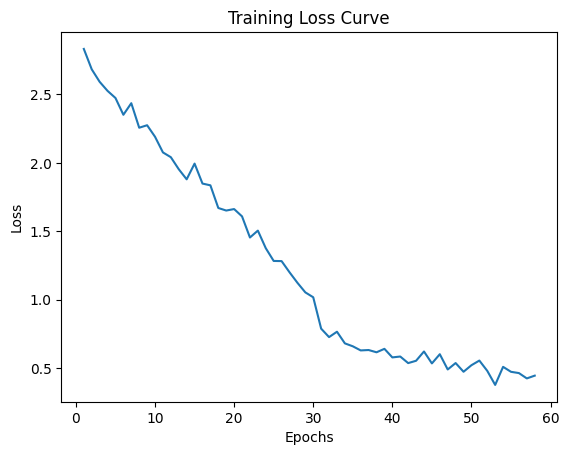

Finished Training Teacher


In [43]:
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs, patience=5)

In [15]:
## backup locally
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'weights/wider/wider_teacher_model_weights_resnet32_4.pth')
torch.save(teacher_model, 'weights/wider/wider_teacher_model_resnet32_4.pth')
print('student weights and architecture saved and exported')

student weights and architecture saved and exported


In [8]:
## load model 
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

teacher_model.load_state_dict(torch.load('weights/wider/wider_teacher_model_weights_resnet32_4_v2.pth'))

<All keys matched successfully>

In [9]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 



# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_resnet32x4_wider.pth'
teacher_model_path = 'models/testing_teacher_model_resnet32x4_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


teacher weights and architecture saved and exported to S3


## Model Evaluation

### Pull Model from S3

In [26]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/teacher_model_resnet32x4_wider.pth'
# student_model_weights_s3_path = 'weights/testing_student_model_weights_rkd_prof.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

######## MAKE SURE THAT YOU HAVE THE CORRECT MODELS FOR WEIGHTS ########
# Teacher
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)
teacher_model.load_state_dict(torch.load(teacher_model_weights_buffer))
teacher_model.eval()
# # Student
# student_model = CustomResNet18()
# student_model.load_state_dict(torch.load(student_model_weights_buffer))


29 Nov 2023 03:07:24 [line:1254] Found credentials in shared credentials file: ~/.aws/credentials


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

# Train with Norm and Direction Framework

In [27]:
import boto3
import io
import os
import torch
import torch.nn as nn
from collections import OrderedDict
import json
import models_package  
import numpy as np


def get_emb_fea(model, dataloader, batch_size):
    ''' Used to extract the feature embeddings in a teacher model '''
    model.eval()

    EMB = {}

    with torch.no_grad():


        for index, data in enumerate(tqdm(trainloader)):
            images = data['img'].to(device)
            labels = data['label'].to(device)
        
        # for images, labels in dataloader:
        #     images, labels = images.cuda(), labels.cuda()

            # compute output
            emb_fea, logits = model(images, embed=True)

            for emb, i in zip(emb_fea, labels):
                i = i.item()
                emb_size = len(emb) 
                if str(i) in EMB:
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))
                else:
                    EMB[str(i)] = [[] for _ in range(emb_size)]
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))

    for key, value in EMB.items():
        for i in range(emb_size):
            EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

    return EMB


def retrieve_teacher_class_weights(model_name, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    # print("Keys in checkpoint:", checkpoint.keys())
    print("model is loaded properly")

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

In [37]:
retrieve_teacher_class_weights(model_name = teacher_name, model_weight_path = teacher_model_weights_s3_path, num_class = 30, data_name = 'wider', dataloader = trainloader, batch_size = batch_size, bucket_name = bucket_name)


29 Nov 2023 01:26:41 [line:1255] Found credentials in shared credentials file: ~/.aws/credentials


model is loaded properly


100%|████████████████████████████████████████████████████████████████████████████████████████| 81/81 [32:23<00:00, 24.00s/it]


## KD++

In [29]:
## Training script

def train(model, teacher, T_EMB, train_dataloader, optimizer, criterion, kd_loss, nd_loss, args, epoch):
    train_loss = AverageMeter()
    train_error = AverageMeter()

    Cls_loss = AverageMeter()
    Div_loss = AverageMeter()
    Norm_Dir_loss = AverageMeter()

    # Model on train mode
    model.train()
    teacher.eval()
    step_per_epoch = len(train_dataloader)

    for step, data in enumerate(train_dataloader):
        start = time.time()
        if torch.cuda.is_available():
            # images, labels = images.cuda(), labels.cuda() 
            images = data['img'].to(device)
            labels = data['label'].to(device)

            # compute output
            s_emb, s_logits = model(images, embed=True)
    
            with torch.no_grad():
                t_emb, t_logits = teacher(images, embed=True)
    
            # cls loss
            cls_loss = criterion(s_logits, labels) * args.cls_loss_factor
            # KD loss
            div_loss = kd_loss(s_out = s_logits, t_out = t_logits) * min(1.0, epoch/args.warm_up)
            # ND loss
            norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)
    
            loss = cls_loss + div_loss + norm_dir_loss
            # measure accuracy and record loss
            batch_size = images.size(0)
            _, pred = s_logits.data.cpu().topk(1, dim=1)
            train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            train_loss.update(loss.item(), batch_size)
    
            Cls_loss.update(cls_loss.item(), batch_size)
            Div_loss.update(div_loss.item(), batch_size)
            Norm_Dir_loss.update(norm_dir_loss.item(), batch_size)
    
            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
            s1 = '\r{} [{}/{}]'.format(t, step+1, step_per_epoch)
            s2 = ' - {:.2f}ms/step - nd_loss: {:.3f} - kd_loss: {:.3f} - cls_loss: {:.3f} - train_loss: {:.3f} - train_acc: {:.3f}'.format(
                 1000 * (time.time() - start), norm_dir_loss.item(), div_loss.item(), cls_loss.item(), train_loss.val, 1-train_error.val)
    
            print(s1+s2, end='', flush=True)

    print()
    return Norm_Dir_loss.avg, Div_loss.avg, Cls_loss.avg, train_loss.avg, train_error.avg


def test(model, test_dataloader, criterion):
    test_loss = AverageMeter()
    test_error = AverageMeter()

    # Model on eval mode
    model.eval()


    with torch.no_grad():
        for _, data in enumerate(test_dataloader):
            images = data['img'].to(device)
            labels = data['label'].to(device)

            # compute logits
            logits = model(images, embed=False)

            loss = criterion(logits, labels)

            # measure accuracy and record loss
            batch_size = images.size(0)
            _, pred = logits.data.cpu().topk(1, dim=1)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg


def epoch_loop(model, teacher, train_loader, test_loader, num_class, args):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # model = nn.DataParallel(model, device_ids=args.gpus)
    model = nn.DataParallel(model)
    model.to(device)
    # teacher = nn.DataParallel(teacher, device_ids=args.gpus)
    teacher = nn.DataParallel(teacher)
    teacher.to(device)

    # loss
    criterion = nn.CrossEntropyLoss().to(device)
    kd_loss = KDLoss(kl_loss_factor=args.kd_loss_factor, T=args.t).to(device)
    nd_loss = DirectNormLoss(num_class=num_class, nd_loss_factor=args.nd_loss_factor).to(device)
    # optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay, nesterov=True)

    # weights
    save_dir = Path(args.save_dir)
    weights = save_dir / 'weights'
    weights.mkdir(parents=True, exist_ok=True)
    last = weights / 'last'
    best = weights / 'best'

    # acc,loss
    acc_loss = save_dir / 'acc_loss'
    acc_loss.mkdir(parents=True, exist_ok=True)

    train_acc_savepath = acc_loss / 'train_acc.npy'
    train_loss_savepath = acc_loss / 'train_loss.npy'
    val_acc_savepath = acc_loss / 'val_acc.npy'
    val_loss_savepath = acc_loss / 'val_loss.npy'

    # tensorboard
    logdir = save_dir / 'logs'
    logdir.mkdir(parents=True, exist_ok=True)
    summary_writer = SummaryWriter(logdir, flush_secs=120)

    # resume
    if args.resume:
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_error = checkpoint['best_error']
        train_acc = checkpoint['train_acc']
        train_loss = checkpoint['train_loss']
        test_acc = checkpoint['test_acc']
        test_loss = checkpoint['test_loss']
        logger.info(colorstr('green', 'Resuming training from {} epoch'.format(start_epoch)))
    else:
        start_epoch = 0
        best_error = 0
        train_acc = []
        train_loss = []
        test_acc = []
        test_loss = []

    # Train model
    best_error = 1
    for epoch in range(start_epoch, args.epochs):
        if epoch in [150, 180, 210]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        print("Epoch {}/{}".format(epoch + 1, args.epochs))
        norm_dir_loss, div_loss, cls_loss, train_epoch_loss, train_error = train(model=model,
                                                                                 teacher=teacher,
                                                                                 T_EMB=T_EMB,
                                                                                 train_dataloader=train_loader,
                                                                                 optimizer=optimizer,
                                                                                 criterion=criterion,
                                                                                 kd_loss=kd_loss,
                                                                                 nd_loss=nd_loss,
                                                                                 args=args,
                                                                                 epoch=epoch)
        test_epoch_loss, test_error = test(model=model,
                                           test_dataloader=test_loader,
                                           criterion=criterion)

        s = "Train Loss: {:.3f}, Train Acc: {:.3f}, Test Loss: {:.3f}, Test Acc: {:.3f}, lr: {:.5f}".format(
            train_epoch_loss, 1-train_error, test_epoch_loss, 1-test_error, optimizer.param_groups[0]['lr'])
        logger.info(colorstr('green', s))

        # save acc,loss
        train_loss.append(train_epoch_loss)
        train_acc.append(1-train_error)
        test_loss.append(test_epoch_loss)
        test_acc.append(1-test_error)

        # save model
        is_best = test_error < best_error
        best_error = min(best_error, test_error)
        state = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_error': best_error,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'test_acc': test_acc,
                'test_loss': test_loss,
            }

        last_path = last / 'epoch_{}_loss_{:.3f}_acc_{:.3f}'.format(
            epoch + 1, test_epoch_loss, 1-test_error)
        best_path = best / 'epoch_{}_acc_{:.3f}'.format(
                epoch + 1, 1-best_error)

        Save_Checkpoint(state, last, last_path, best, best_path, is_best)

        # tensorboard
        if epoch == 1:
            # images, labels = next(iter(train_loader))
            data = next(iter(train_loader))
            images = data['img'].to(device)
            labels = data['label'].to(device)

            img_grid = torchvision.utils.make_grid(images)
            summary_writer.add_image('Image', img_grid)
        summary_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
        summary_writer.add_scalar('train_loss', train_epoch_loss, epoch)
        summary_writer.add_scalar('train_error', train_error, epoch)
        summary_writer.add_scalar('val_loss', test_epoch_loss, epoch)
        summary_writer.add_scalar('val_error', test_error, epoch)

        summary_writer.add_scalar('nd_loss', norm_dir_loss, epoch)
        summary_writer.add_scalar('kd_loss', div_loss, epoch)
        summary_writer.add_scalar('cls_loss', cls_loss, epoch)

    summary_writer.close()
    import os
    if not os.path.exists(train_acc_savepath) or not os.path.exists(train_loss_savepath):
        np.save(train_acc_savepath, train_acc)
        np.save(train_loss_savepath, train_loss)
        np.save(val_acc_savepath, test_acc)
        np.save(val_loss_savepath, test_loss)


In [30]:
# images, labels = next(iter(train_loader))

In [31]:

if __name__ == "__main__":
    model_names = sorted(name for name in models_package.__dict__
                         if name.islower() and not name.startswith("__")
                         and callable(models_package.__dict__[name]))

    parser = argparse.ArgumentParser(description='PyTorch Cifar Training')
    parser.add_argument('-f') # added to make this run in collab
    parser.add_argument("--model_name", type=str, default="resnet8x4_wider", choices=model_names, help="model architecture")
    parser.add_argument("--dataset", type=str, default='wider')
    parser.add_argument("--num_class", type=int, default=30, help="number of classes in dataset")

    parser.add_argument("--epochs", type=int, default=240)
    # parser.add_argument("--epochs", type=int, default=4)
    parser.add_argument("--batch_size", type=int, default=300, help="batch size per gpu")
    parser.add_argument('--workers', default=8, type=int, help='number of data loading workers')
    parser.add_argument("--lr", type=float, default=0.1)
    parser.add_argument('--momentum', type=float, default=0.9, help='SGD momentum')
    parser.add_argument("--weight_decay", type=float, default=5e-4)

    parser.add_argument("--teacher", type=str, default="resnet32x4_wider", help="teacher architecture")
    parser.add_argument("--teacher_weights", type=str, default="weights/teacher_model_resnet32x4_wider.pth", help="teacher weights path")
    parser.add_argument("--cls_loss_factor", type=float, default=1.0, help="cls loss weight factor")
    parser.add_argument("--kd_loss_factor", type=float, default=1.0, help="KD loss weight factor")
    parser.add_argument("--t", type=float, default=4.0, help="temperature")
    parser.add_argument("--nd_loss_factor", type=float, default=1.0, help="ND loss weight factor")
    parser.add_argument("--warm_up", type=float, default=20.0, help='loss weight warm up epochs')

    parser.add_argument("--gpus", type=list, default=[0, 1])
    parser.add_argument('--seed', default=None, type=int, help='seed for initializing training.')
    parser.add_argument("--resume", type=str, help="best ckpt's path to resume most recent training")
    parser.add_argument("--save_dir", type=str, default="./run/WIDER/KD++", help="save path, eg, acc_loss, weights, tensorboard, and so on")
    args = parser.parse_args()

    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True
        cudnn.benchmark = False
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    logging.basicConfig(level=logging.INFO, format='%(asctime)s [line:%(lineno)d] %(message)s',
                        datefmt='%d %b %Y %H:%M:%S')
    logger = logging.getLogger(__name__)

    args.batch_size = args.batch_size * len(args.gpus)
    # args.batch_size = args.batch_size * 1

    # logger.info(colorstr('green', "Distribute train, gpus:{}, total batch size:{}, epoch:{}".format(args.gpus, args.batch_size, args.epochs)))
    logger.info(colorstr('green', "Distribute train, total batch size:{}, epoch:{}".format(args.batch_size, args.epochs)))


    # train_set, test_set, num_class = IDENPROF(name=args.dataset)
    model = models_package.__dict__[args.model_name](num_class=args.num_class)

    # if args.model_name in ['wrn40_1_cifar', 'mobilenetv2', 'shufflev1_cifar', 'shufflev2_cifar']:
    #     model = EmbTrans(student=model, model_name=args.model_name)

    teacher = models_package.__dict__[args.teacher](num_class=args.num_class)

    if args.teacher_weights:
        print('Load Teacher Weights')
        session = boto3.session.Session()
        s3 = session.client('s3')
        bucket_name = '210bucket'  
        
        teacher_model_weights_buffer = io.BytesIO()
        print(bucket_name)
        print(teacher_model_weights_s3_path)
        s3.download_fileobj(bucket_name, args.teacher_weights, teacher_model_weights_buffer)
        teacher_model_weights_buffer.seek(0)  

        # Load the model
        # model = models_package.__dict__[model_name](num_class=num_class)
        teacher_ckpt = torch.load(teacher_model_weights_buffer)
        teacher.load_state_dict(teacher_ckpt)
        
        for param in teacher.parameters():
            param.requires_grad = False

    # res56    ./ckpt/teacher/resnet56/center_emb_train.json
    # res32x4  ./ckpt/teacher/resnet32x4/center_emb_train.json
    # wrn40_2  ./ckpt/teacher/wrn_40_2/center_emb_train.json
    # res50    ./ckpt/teacher/resnet50/center_emb_train.json
    # class-mean
    with open("./class_means/wider_embedding_fea/resnet32x4_wider.json", 'r') as f:
        T_EMB = json.load(f)
    f.close()

    logger.info(colorstr('green', 'Use ' + args.teacher + ' Training ' + args.model_name + ' ...'))
    # Train the model
    epoch_loop(model=model, teacher=teacher, train_loader = trainloader, test_loader = testloader, num_class = num_class, args=args)


29 Nov 2023 03:07:35 [line:53] Distribute train, total batch size:600, epoch:240
29 Nov 2023 03:07:35 [line:1254] Found credentials in shared credentials file: ~/.aws/credentials


Load Teacher Weights
210bucket
weights/teacher_model_resnet32x4_wider.pth


29 Nov 2023 03:07:36 [line:93] Use resnet32x4_wider Training resnet8x4_wider ...


Epoch 1/240
2023-11-29 03:14:35 [162/162] - 737.21ms/step - nd_loss: 1.000 - kd_loss: 0.000 - cls_loss: 3.370 - train_loss: 4.370 - train_acc: 0.100694


29 Nov 2023 03:14:54 [line:171] Train Loss: 5.478, Train Acc: 0.087, Test Loss: 3.299, Test Acc: 0.092, lr: 0.10000


Epoch 2/240
2023-11-29 03:21:52 [162/162] - 728.40ms/step - nd_loss: 1.000 - kd_loss: 0.303 - cls_loss: 3.220 - train_loss: 4.524 - train_acc: 0.0509


29 Nov 2023 03:22:12 [line:171] Train Loss: 4.558, Train Acc: 0.092, Test Loss: 3.299, Test Acc: 0.092, lr: 0.10000


Epoch 3/240
2023-11-29 03:29:15 [162/162] - 728.86ms/step - nd_loss: 1.000 - kd_loss: 0.517 - cls_loss: 3.299 - train_loss: 4.816 - train_acc: 0.0504


29 Nov 2023 03:29:34 [line:171] Train Loss: 4.816, Train Acc: 0.093, Test Loss: 3.301, Test Acc: 0.092, lr: 0.10000


Epoch 4/240
2023-11-29 03:36:31 [162/162] - 729.03ms/step - nd_loss: 1.000 - kd_loss: 0.652 - cls_loss: 3.353 - train_loss: 5.004 - train_acc: 0.1504


29 Nov 2023 03:36:51 [line:171] Train Loss: 5.070, Train Acc: 0.092, Test Loss: 3.303, Test Acc: 0.092, lr: 0.10000


Epoch 5/240
2023-11-29 03:43:49 [162/162] - 729.52ms/step - nd_loss: 1.000 - kd_loss: 0.755 - cls_loss: 3.279 - train_loss: 5.034 - train_acc: 0.0505


29 Nov 2023 03:44:08 [line:171] Train Loss: 5.324, Train Acc: 0.093, Test Loss: 3.305, Test Acc: 0.092, lr: 0.10000


Epoch 6/240
2023-11-29 03:51:05 [162/162] - 729.55ms/step - nd_loss: 1.000 - kd_loss: 1.200 - cls_loss: 3.464 - train_loss: 5.664 - train_acc: 0.0504


29 Nov 2023 03:51:25 [line:171] Train Loss: 5.588, Train Acc: 0.092, Test Loss: 3.307, Test Acc: 0.092, lr: 0.10000


Epoch 7/240
2023-11-29 03:58:22 [162/162] - 729.91ms/step - nd_loss: 1.000 - kd_loss: 1.642 - cls_loss: 3.157 - train_loss: 5.799 - train_acc: 0.2008


29 Nov 2023 03:58:42 [line:171] Train Loss: 5.844, Train Acc: 0.093, Test Loss: 3.310, Test Acc: 0.092, lr: 0.10000


Epoch 8/240
2023-11-29 04:05:40 [162/162] - 729.59ms/step - nd_loss: 1.000 - kd_loss: 1.869 - cls_loss: 3.269 - train_loss: 6.138 - train_acc: 0.0501


29 Nov 2023 04:06:00 [line:171] Train Loss: 6.086, Train Acc: 0.093, Test Loss: 3.313, Test Acc: 0.092, lr: 0.10000


Epoch 9/240
2023-11-29 04:12:57 [162/162] - 732.32ms/step - nd_loss: 1.000 - kd_loss: 2.456 - cls_loss: 3.418 - train_loss: 6.874 - train_acc: 0.0505


29 Nov 2023 04:13:17 [line:171] Train Loss: 6.351, Train Acc: 0.092, Test Loss: 3.312, Test Acc: 0.092, lr: 0.10000


Epoch 10/240
2023-11-29 04:20:15 [162/162] - 728.25ms/step - nd_loss: 1.000 - kd_loss: 2.189 - cls_loss: 3.537 - train_loss: 6.726 - train_acc: 0.0001


29 Nov 2023 04:20:35 [line:171] Train Loss: 6.586, Train Acc: 0.093, Test Loss: 3.319, Test Acc: 0.092, lr: 0.10000


Epoch 11/240
2023-11-29 04:27:32 [162/162] - 729.38ms/step - nd_loss: 1.000 - kd_loss: 2.466 - cls_loss: 3.322 - train_loss: 6.788 - train_acc: 0.0507


29 Nov 2023 04:27:52 [line:171] Train Loss: 6.861, Train Acc: 0.093, Test Loss: 3.317, Test Acc: 0.092, lr: 0.10000


Epoch 12/240
2023-11-29 04:34:50 [162/162] - 729.29ms/step - nd_loss: 1.000 - kd_loss: 3.525 - cls_loss: 3.184 - train_loss: 7.708 - train_acc: 0.1009


29 Nov 2023 04:35:10 [line:171] Train Loss: 7.105, Train Acc: 0.092, Test Loss: 3.320, Test Acc: 0.092, lr: 0.10000


Epoch 13/240
2023-11-29 04:42:08 [162/162] - 730.23ms/step - nd_loss: 1.000 - kd_loss: 2.120 - cls_loss: 3.439 - train_loss: 6.559 - train_acc: 0.0009


29 Nov 2023 04:42:29 [line:171] Train Loss: 7.379, Train Acc: 0.093, Test Loss: 3.323, Test Acc: 0.092, lr: 0.10000


Epoch 14/240
2023-11-29 04:49:28 [162/162] - 731.37ms/step - nd_loss: 1.000 - kd_loss: 2.460 - cls_loss: 3.194 - train_loss: 6.654 - train_acc: 0.1506


29 Nov 2023 04:49:48 [line:171] Train Loss: 7.589, Train Acc: 0.091, Test Loss: 3.331, Test Acc: 0.092, lr: 0.10000


Epoch 15/240
2023-11-29 04:56:46 [162/162] - 728.38ms/step - nd_loss: 1.000 - kd_loss: 4.193 - cls_loss: 3.631 - train_loss: 8.824 - train_acc: 0.0001


29 Nov 2023 04:57:06 [line:171] Train Loss: 7.865, Train Acc: 0.092, Test Loss: 3.327, Test Acc: 0.092, lr: 0.10000


Epoch 16/240
2023-11-29 05:04:04 [162/162] - 728.66ms/step - nd_loss: 1.000 - kd_loss: 3.477 - cls_loss: 3.362 - train_loss: 7.838 - train_acc: 0.2002


29 Nov 2023 05:04:24 [line:171] Train Loss: 8.134, Train Acc: 0.093, Test Loss: 3.329, Test Acc: 0.092, lr: 0.10000


Epoch 17/240
2023-11-29 05:11:22 [162/162] - 729.25ms/step - nd_loss: 1.000 - kd_loss: 4.899 - cls_loss: 3.404 - train_loss: 9.302 - train_acc: 0.0001


29 Nov 2023 05:11:43 [line:171] Train Loss: 8.381, Train Acc: 0.093, Test Loss: 3.333, Test Acc: 0.092, lr: 0.10000


Epoch 18/240
2023-11-29 05:18:41 [162/162] - 730.68ms/step - nd_loss: 1.000 - kd_loss: 3.703 - cls_loss: 3.510 - train_loss: 8.213 - train_acc: 0.0502


29 Nov 2023 05:19:02 [line:171] Train Loss: 8.631, Train Acc: 0.091, Test Loss: 3.336, Test Acc: 0.092, lr: 0.10000


Epoch 19/240
2023-11-29 05:26:01 [162/162] - 728.97ms/step - nd_loss: 1.000 - kd_loss: 5.540 - cls_loss: 3.264 - train_loss: 9.804 - train_acc: 0.05098


29 Nov 2023 05:26:21 [line:171] Train Loss: 8.853, Train Acc: 0.093, Test Loss: 3.341, Test Acc: 0.092, lr: 0.10000


Epoch 20/240
2023-11-29 05:33:21 [162/162] - 728.91ms/step - nd_loss: 1.000 - kd_loss: 3.925 - cls_loss: 3.259 - train_loss: 8.184 - train_acc: 0.1002


29 Nov 2023 05:33:41 [line:171] Train Loss: 9.174, Train Acc: 0.093, Test Loss: 3.349, Test Acc: 0.092, lr: 0.10000


Epoch 21/240
2023-11-29 05:40:39 [162/162] - 729.87ms/step - nd_loss: 1.000 - kd_loss: 6.304 - cls_loss: 3.455 - train_loss: 10.758 - train_acc: 0.0502


29 Nov 2023 05:40:59 [line:171] Train Loss: 9.402, Train Acc: 0.090, Test Loss: 3.340, Test Acc: 0.092, lr: 0.10000


Epoch 22/240
2023-11-29 05:47:58 [162/162] - 729.71ms/step - nd_loss: 1.000 - kd_loss: 5.342 - cls_loss: 3.487 - train_loss: 9.829 - train_acc: 0.05071


29 Nov 2023 05:48:19 [line:171] Train Loss: 9.394, Train Acc: 0.093, Test Loss: 3.341, Test Acc: 0.092, lr: 0.10000


Epoch 23/240
2023-11-29 05:55:17 [162/162] - 729.86ms/step - nd_loss: 1.000 - kd_loss: 5.754 - cls_loss: 3.184 - train_loss: 9.938 - train_acc: 0.15028


29 Nov 2023 05:55:37 [line:171] Train Loss: 9.381, Train Acc: 0.093, Test Loss: 3.345, Test Acc: 0.092, lr: 0.10000


Epoch 24/240
2023-11-29 06:02:36 [162/162] - 730.49ms/step - nd_loss: 1.000 - kd_loss: 5.254 - cls_loss: 3.316 - train_loss: 9.569 - train_acc: 0.10078


29 Nov 2023 06:02:57 [line:171] Train Loss: 9.375, Train Acc: 0.093, Test Loss: 3.352, Test Acc: 0.092, lr: 0.10000


Epoch 25/240
2023-11-29 06:09:57 [162/162] - 731.54ms/step - nd_loss: 1.000 - kd_loss: 5.366 - cls_loss: 3.743 - train_loss: 10.109 - train_acc: 0.1008


29 Nov 2023 06:10:18 [line:171] Train Loss: 9.382, Train Acc: 0.093, Test Loss: 3.344, Test Acc: 0.092, lr: 0.10000


Epoch 26/240
2023-11-29 06:17:18 [162/162] - 732.03ms/step - nd_loss: 1.000 - kd_loss: 5.027 - cls_loss: 3.423 - train_loss: 9.450 - train_acc: 0.00098


29 Nov 2023 06:17:39 [line:171] Train Loss: 9.409, Train Acc: 0.093, Test Loss: 3.340, Test Acc: 0.092, lr: 0.10000


Epoch 27/240
2023-11-29 06:24:39 [162/162] - 729.39ms/step - nd_loss: 1.000 - kd_loss: 5.289 - cls_loss: 3.257 - train_loss: 9.546 - train_acc: 0.15064


29 Nov 2023 06:24:59 [line:171] Train Loss: 9.392, Train Acc: 0.093, Test Loss: 3.345, Test Acc: 0.092, lr: 0.10000


Epoch 28/240
2023-11-29 06:31:59 [162/162] - 729.89ms/step - nd_loss: 0.997 - kd_loss: 4.234 - cls_loss: 3.190 - train_loss: 8.421 - train_acc: 0.1004


29 Nov 2023 06:32:20 [line:171] Train Loss: 9.229, Train Acc: 0.105, Test Loss: 3.263, Test Acc: 0.141, lr: 0.10000


Epoch 29/240
2023-11-29 06:39:21 [162/162] - 731.39ms/step - nd_loss: 0.998 - kd_loss: 3.877 - cls_loss: 3.351 - train_loss: 8.226 - train_acc: 0.1504


29 Nov 2023 06:39:42 [line:171] Train Loss: 9.099, Train Acc: 0.121, Test Loss: 3.231, Test Acc: 0.128, lr: 0.10000


Epoch 30/240
2023-11-29 06:46:43 [162/162] - 735.08ms/step - nd_loss: 0.999 - kd_loss: 4.766 - cls_loss: 3.182 - train_loss: 8.947 - train_acc: 0.05044


29 Nov 2023 06:47:04 [line:171] Train Loss: 9.055, Train Acc: 0.122, Test Loss: 3.158, Test Acc: 0.156, lr: 0.10000


Epoch 31/240
2023-11-29 06:54:05 [162/162] - 730.74ms/step - nd_loss: 0.998 - kd_loss: 4.536 - cls_loss: 3.186 - train_loss: 8.720 - train_acc: 0.15068


29 Nov 2023 06:54:27 [line:171] Train Loss: 8.951, Train Acc: 0.130, Test Loss: 3.152, Test Acc: 0.143, lr: 0.10000


Epoch 32/240
2023-11-29 07:01:28 [162/162] - 732.46ms/step - nd_loss: 0.994 - kd_loss: 3.982 - cls_loss: 3.133 - train_loss: 8.109 - train_acc: 0.15069


29 Nov 2023 07:01:50 [line:171] Train Loss: 8.822, Train Acc: 0.134, Test Loss: 3.056, Test Acc: 0.176, lr: 0.10000


Epoch 33/240
2023-11-29 07:08:52 [162/162] - 732.06ms/step - nd_loss: 0.989 - kd_loss: 4.229 - cls_loss: 2.823 - train_loss: 8.041 - train_acc: 0.3003


29 Nov 2023 07:09:13 [line:171] Train Loss: 8.158, Train Acc: 0.173, Test Loss: 3.162, Test Acc: 0.191, lr: 0.10000


Epoch 34/240
2023-11-29 07:16:14 [162/162] - 729.73ms/step - nd_loss: 0.984 - kd_loss: 3.798 - cls_loss: 3.032 - train_loss: 7.814 - train_acc: 0.2009


29 Nov 2023 07:16:34 [line:171] Train Loss: 7.690, Train Acc: 0.203, Test Loss: 2.800, Test Acc: 0.245, lr: 0.10000


Epoch 35/240
2023-11-29 07:23:35 [162/162] - 729.73ms/step - nd_loss: 0.983 - kd_loss: 3.265 - cls_loss: 2.475 - train_loss: 6.722 - train_acc: 0.3501


29 Nov 2023 07:23:55 [line:171] Train Loss: 7.191, Train Acc: 0.235, Test Loss: 2.856, Test Acc: 0.270, lr: 0.10000


Epoch 36/240
2023-11-29 07:30:56 [162/162] - 730.20ms/step - nd_loss: 0.981 - kd_loss: 3.037 - cls_loss: 2.982 - train_loss: 7.000 - train_acc: 0.2006


29 Nov 2023 07:31:16 [line:171] Train Loss: 6.866, Train Acc: 0.252, Test Loss: 2.559, Test Acc: 0.321, lr: 0.10000


Epoch 37/240
2023-11-29 07:38:17 [162/162] - 730.18ms/step - nd_loss: 0.981 - kd_loss: 2.400 - cls_loss: 2.619 - train_loss: 6.000 - train_acc: 0.3008


29 Nov 2023 07:38:37 [line:171] Train Loss: 6.503, Train Acc: 0.284, Test Loss: 2.334, Test Acc: 0.352, lr: 0.10000


Epoch 38/240
2023-11-29 07:45:38 [162/162] - 729.45ms/step - nd_loss: 0.979 - kd_loss: 3.360 - cls_loss: 2.280 - train_loss: 6.619 - train_acc: 0.4503


29 Nov 2023 07:45:59 [line:171] Train Loss: 6.294, Train Acc: 0.297, Test Loss: 2.593, Test Acc: 0.353, lr: 0.10000


Epoch 39/240
2023-11-29 07:52:59 [162/162] - 729.72ms/step - nd_loss: 0.979 - kd_loss: 3.938 - cls_loss: 2.361 - train_loss: 7.278 - train_acc: 0.3002


29 Nov 2023 07:53:20 [line:171] Train Loss: 6.159, Train Acc: 0.307, Test Loss: 2.734, Test Acc: 0.324, lr: 0.10000


Epoch 40/240
2023-11-29 08:00:21 [162/162] - 728.09ms/step - nd_loss: 0.977 - kd_loss: 2.066 - cls_loss: 2.074 - train_loss: 5.117 - train_acc: 0.5508


29 Nov 2023 08:00:41 [line:171] Train Loss: 5.846, Train Acc: 0.326, Test Loss: 2.229, Test Acc: 0.396, lr: 0.10000


Epoch 41/240
2023-11-29 08:07:41 [162/162] - 729.09ms/step - nd_loss: 0.976 - kd_loss: 1.894 - cls_loss: 2.170 - train_loss: 5.040 - train_acc: 0.4504


29 Nov 2023 08:08:02 [line:171] Train Loss: 5.680, Train Acc: 0.339, Test Loss: 2.025, Test Acc: 0.439, lr: 0.10000


Epoch 42/240
2023-11-29 08:15:02 [162/162] - 728.55ms/step - nd_loss: 0.974 - kd_loss: 2.131 - cls_loss: 2.420 - train_loss: 5.525 - train_acc: 0.4001


29 Nov 2023 08:15:22 [line:171] Train Loss: 5.539, Train Acc: 0.349, Test Loss: 2.061, Test Acc: 0.419, lr: 0.10000


Epoch 43/240
2023-11-29 08:22:22 [162/162] - 728.52ms/step - nd_loss: 0.973 - kd_loss: 1.857 - cls_loss: 1.697 - train_loss: 4.527 - train_acc: 0.4501


29 Nov 2023 08:22:42 [line:171] Train Loss: 5.342, Train Acc: 0.370, Test Loss: 1.959, Test Acc: 0.458, lr: 0.10000


Epoch 44/240
2023-11-29 08:29:42 [162/162] - 729.34ms/step - nd_loss: 0.974 - kd_loss: 2.510 - cls_loss: 2.665 - train_loss: 6.149 - train_acc: 0.2506


29 Nov 2023 08:30:02 [line:171] Train Loss: 5.242, Train Acc: 0.370, Test Loss: 1.817, Test Acc: 0.476, lr: 0.10000


Epoch 45/240
2023-11-29 08:37:02 [162/162] - 729.86ms/step - nd_loss: 0.974 - kd_loss: 3.251 - cls_loss: 2.919 - train_loss: 7.143 - train_acc: 0.3008


29 Nov 2023 08:37:23 [line:171] Train Loss: 5.148, Train Acc: 0.380, Test Loss: 2.062, Test Acc: 0.419, lr: 0.10000


Epoch 46/240
2023-11-29 08:44:23 [162/162] - 727.60ms/step - nd_loss: 0.972 - kd_loss: 1.602 - cls_loss: 2.041 - train_loss: 4.615 - train_acc: 0.5004


29 Nov 2023 08:44:43 [line:171] Train Loss: 5.053, Train Acc: 0.390, Test Loss: 1.815, Test Acc: 0.494, lr: 0.10000


Epoch 47/240
2023-11-29 08:51:43 [162/162] - 730.34ms/step - nd_loss: 0.970 - kd_loss: 1.631 - cls_loss: 2.096 - train_loss: 4.696 - train_acc: 0.5006


29 Nov 2023 08:52:04 [line:171] Train Loss: 4.949, Train Acc: 0.402, Test Loss: 1.812, Test Acc: 0.486, lr: 0.10000


Epoch 48/240
2023-11-29 08:59:03 [162/162] - 730.82ms/step - nd_loss: 0.971 - kd_loss: 2.454 - cls_loss: 2.342 - train_loss: 5.767 - train_acc: 0.3009


29 Nov 2023 08:59:24 [line:171] Train Loss: 4.882, Train Acc: 0.405, Test Loss: 1.768, Test Acc: 0.500, lr: 0.10000


Epoch 49/240
2023-11-29 09:06:24 [162/162] - 731.54ms/step - nd_loss: 0.966 - kd_loss: 1.511 - cls_loss: 1.348 - train_loss: 3.825 - train_acc: 0.6006


29 Nov 2023 09:06:44 [line:171] Train Loss: 4.836, Train Acc: 0.410, Test Loss: 1.798, Test Acc: 0.492, lr: 0.10000


Epoch 50/240
2023-11-29 09:13:45 [162/162] - 727.67ms/step - nd_loss: 0.966 - kd_loss: 2.037 - cls_loss: 2.474 - train_loss: 5.477 - train_acc: 0.2508


29 Nov 2023 09:14:05 [line:171] Train Loss: 4.757, Train Acc: 0.421, Test Loss: 2.127, Test Acc: 0.439, lr: 0.10000


Epoch 51/240
2023-11-29 09:21:05 [162/162] - 727.54ms/step - nd_loss: 0.965 - kd_loss: 1.707 - cls_loss: 1.911 - train_loss: 4.583 - train_acc: 0.5001


29 Nov 2023 09:21:25 [line:171] Train Loss: 4.726, Train Acc: 0.426, Test Loss: 1.673, Test Acc: 0.526, lr: 0.10000


Epoch 52/240
2023-11-29 09:28:26 [162/162] - 729.44ms/step - nd_loss: 0.964 - kd_loss: 1.724 - cls_loss: 2.567 - train_loss: 5.255 - train_acc: 0.4006


29 Nov 2023 09:28:46 [line:171] Train Loss: 4.634, Train Acc: 0.423, Test Loss: 1.594, Test Acc: 0.536, lr: 0.10000


Epoch 53/240
2023-11-29 09:35:47 [162/162] - 728.53ms/step - nd_loss: 0.964 - kd_loss: 1.862 - cls_loss: 1.848 - train_loss: 4.674 - train_acc: 0.5009


29 Nov 2023 09:36:07 [line:171] Train Loss: 4.538, Train Acc: 0.436, Test Loss: 1.455, Test Acc: 0.574, lr: 0.10000


Epoch 54/240
2023-11-29 09:43:07 [162/162] - 730.03ms/step - nd_loss: 0.965 - kd_loss: 2.191 - cls_loss: 2.215 - train_loss: 5.371 - train_acc: 0.3004


29 Nov 2023 09:43:28 [line:171] Train Loss: 4.541, Train Acc: 0.434, Test Loss: 1.553, Test Acc: 0.551, lr: 0.10000


Epoch 55/240
2023-11-29 09:50:28 [162/162] - 728.47ms/step - nd_loss: 0.966 - kd_loss: 2.119 - cls_loss: 2.032 - train_loss: 5.117 - train_acc: 0.4006


29 Nov 2023 09:50:48 [line:171] Train Loss: 4.496, Train Acc: 0.439, Test Loss: 1.510, Test Acc: 0.562, lr: 0.10000


Epoch 56/240
2023-11-29 09:57:48 [162/162] - 728.42ms/step - nd_loss: 0.962 - kd_loss: 1.547 - cls_loss: 2.407 - train_loss: 4.917 - train_acc: 0.3504


29 Nov 2023 09:58:08 [line:171] Train Loss: 4.450, Train Acc: 0.444, Test Loss: 1.657, Test Acc: 0.518, lr: 0.10000


Epoch 57/240
2023-11-29 10:05:09 [162/162] - 729.47ms/step - nd_loss: 0.957 - kd_loss: 1.090 - cls_loss: 1.678 - train_loss: 3.725 - train_acc: 0.5008


29 Nov 2023 10:05:30 [line:171] Train Loss: 4.385, Train Acc: 0.445, Test Loss: 1.497, Test Acc: 0.578, lr: 0.10000


Epoch 58/240
2023-11-29 10:12:30 [162/162] - 730.19ms/step - nd_loss: 0.959 - kd_loss: 1.652 - cls_loss: 1.806 - train_loss: 4.417 - train_acc: 0.4508


29 Nov 2023 10:12:50 [line:171] Train Loss: 4.358, Train Acc: 0.451, Test Loss: 1.456, Test Acc: 0.571, lr: 0.10000


Epoch 59/240
2023-11-29 10:19:51 [162/162] - 727.40ms/step - nd_loss: 0.961 - kd_loss: 1.560 - cls_loss: 1.573 - train_loss: 4.094 - train_acc: 0.5000


29 Nov 2023 10:20:11 [line:171] Train Loss: 4.309, Train Acc: 0.454, Test Loss: 1.368, Test Acc: 0.607, lr: 0.10000


Epoch 60/240
2023-11-29 10:27:12 [162/162] - 731.55ms/step - nd_loss: 0.955 - kd_loss: 1.505 - cls_loss: 1.718 - train_loss: 4.177 - train_acc: 0.6000


29 Nov 2023 10:27:34 [line:171] Train Loss: 4.258, Train Acc: 0.470, Test Loss: 1.283, Test Acc: 0.617, lr: 0.10000


Epoch 61/240
2023-11-29 10:34:35 [162/162] - 730.55ms/step - nd_loss: 0.955 - kd_loss: 1.005 - cls_loss: 2.159 - train_loss: 4.119 - train_acc: 0.4000


29 Nov 2023 10:34:55 [line:171] Train Loss: 4.224, Train Acc: 0.468, Test Loss: 1.460, Test Acc: 0.580, lr: 0.10000


Epoch 62/240
2023-11-29 10:41:55 [162/162] - 729.54ms/step - nd_loss: 0.957 - kd_loss: 1.926 - cls_loss: 1.561 - train_loss: 4.444 - train_acc: 0.4509


29 Nov 2023 10:42:16 [line:171] Train Loss: 4.195, Train Acc: 0.475, Test Loss: 1.321, Test Acc: 0.611, lr: 0.10000


Epoch 63/240
2023-11-29 10:49:16 [162/162] - 729.54ms/step - nd_loss: 0.956 - kd_loss: 1.631 - cls_loss: 2.025 - train_loss: 4.612 - train_acc: 0.4008


29 Nov 2023 10:49:36 [line:171] Train Loss: 4.171, Train Acc: 0.473, Test Loss: 1.484, Test Acc: 0.576, lr: 0.10000


Epoch 64/240
2023-11-29 10:56:36 [162/162] - 730.09ms/step - nd_loss: 0.954 - kd_loss: 1.823 - cls_loss: 1.782 - train_loss: 4.558 - train_acc: 0.3006


29 Nov 2023 10:56:56 [line:171] Train Loss: 4.105, Train Acc: 0.483, Test Loss: 1.644, Test Acc: 0.547, lr: 0.10000


Epoch 65/240
2023-11-29 11:03:56 [162/162] - 730.30ms/step - nd_loss: 0.955 - kd_loss: 1.586 - cls_loss: 2.329 - train_loss: 4.869 - train_acc: 0.3008


29 Nov 2023 11:04:17 [line:171] Train Loss: 4.090, Train Acc: 0.478, Test Loss: 1.403, Test Acc: 0.589, lr: 0.10000


Epoch 66/240
2023-11-29 11:11:17 [162/162] - 729.79ms/step - nd_loss: 0.954 - kd_loss: 1.684 - cls_loss: 1.924 - train_loss: 4.561 - train_acc: 0.4506


29 Nov 2023 11:11:38 [line:171] Train Loss: 4.054, Train Acc: 0.490, Test Loss: 1.654, Test Acc: 0.530, lr: 0.10000


Epoch 67/240
2023-11-29 11:18:39 [162/162] - 729.10ms/step - nd_loss: 0.954 - kd_loss: 1.302 - cls_loss: 1.848 - train_loss: 4.103 - train_acc: 0.3509


29 Nov 2023 11:18:59 [line:171] Train Loss: 4.024, Train Acc: 0.486, Test Loss: 1.217, Test Acc: 0.624, lr: 0.10000


Epoch 68/240
2023-11-29 11:25:59 [162/162] - 729.73ms/step - nd_loss: 0.950 - kd_loss: 1.154 - cls_loss: 1.861 - train_loss: 3.964 - train_acc: 0.3506


29 Nov 2023 11:26:19 [line:171] Train Loss: 3.983, Train Acc: 0.493, Test Loss: 1.212, Test Acc: 0.636, lr: 0.10000


Epoch 69/240
2023-11-29 11:33:20 [162/162] - 730.08ms/step - nd_loss: 0.951 - kd_loss: 1.199 - cls_loss: 1.954 - train_loss: 4.105 - train_acc: 0.4501


29 Nov 2023 11:33:39 [line:171] Train Loss: 3.913, Train Acc: 0.506, Test Loss: 1.198, Test Acc: 0.630, lr: 0.10000


Epoch 70/240
2023-11-29 11:40:39 [162/162] - 729.00ms/step - nd_loss: 0.950 - kd_loss: 1.030 - cls_loss: 1.709 - train_loss: 3.688 - train_acc: 0.5000


29 Nov 2023 11:40:59 [line:171] Train Loss: 3.936, Train Acc: 0.498, Test Loss: 1.228, Test Acc: 0.637, lr: 0.10000


Epoch 71/240
2023-11-29 11:47:59 [162/162] - 728.30ms/step - nd_loss: 0.946 - kd_loss: 1.293 - cls_loss: 1.354 - train_loss: 3.593 - train_acc: 0.5504


29 Nov 2023 11:48:19 [line:171] Train Loss: 3.922, Train Acc: 0.502, Test Loss: 1.193, Test Acc: 0.648, lr: 0.10000


Epoch 72/240
2023-11-29 11:55:20 [162/162] - 729.99ms/step - nd_loss: 0.948 - kd_loss: 1.130 - cls_loss: 1.729 - train_loss: 3.807 - train_acc: 0.5002


29 Nov 2023 11:55:40 [line:171] Train Loss: 3.880, Train Acc: 0.509, Test Loss: 1.344, Test Acc: 0.592, lr: 0.10000


Epoch 73/240
2023-11-29 12:02:41 [162/162] - 730.59ms/step - nd_loss: 0.952 - kd_loss: 1.628 - cls_loss: 1.539 - train_loss: 4.118 - train_acc: 0.6006


29 Nov 2023 12:03:00 [line:171] Train Loss: 3.849, Train Acc: 0.508, Test Loss: 1.302, Test Acc: 0.614, lr: 0.10000


Epoch 74/240
2023-11-29 12:10:01 [162/162] - 729.20ms/step - nd_loss: 0.946 - kd_loss: 1.027 - cls_loss: 2.143 - train_loss: 4.116 - train_acc: 0.4509


29 Nov 2023 12:10:20 [line:171] Train Loss: 3.827, Train Acc: 0.510, Test Loss: 1.041, Test Acc: 0.686, lr: 0.10000


Epoch 75/240
2023-11-29 12:17:20 [162/162] - 729.89ms/step - nd_loss: 0.951 - kd_loss: 1.224 - cls_loss: 1.919 - train_loss: 4.093 - train_acc: 0.4506


29 Nov 2023 12:17:41 [line:171] Train Loss: 3.798, Train Acc: 0.514, Test Loss: 1.499, Test Acc: 0.581, lr: 0.10000


Epoch 76/240
2023-11-29 12:24:41 [162/162] - 729.72ms/step - nd_loss: 0.950 - kd_loss: 1.359 - cls_loss: 1.774 - train_loss: 4.084 - train_acc: 0.5009


29 Nov 2023 12:25:01 [line:171] Train Loss: 3.795, Train Acc: 0.526, Test Loss: 1.089, Test Acc: 0.663, lr: 0.10000


Epoch 77/240
2023-11-29 12:32:02 [162/162] - 731.20ms/step - nd_loss: 0.952 - kd_loss: 1.508 - cls_loss: 2.028 - train_loss: 4.487 - train_acc: 0.4009


29 Nov 2023 12:32:23 [line:171] Train Loss: 3.794, Train Acc: 0.516, Test Loss: 1.226, Test Acc: 0.637, lr: 0.10000


Epoch 78/240
2023-11-29 12:39:24 [162/162] - 731.53ms/step - nd_loss: 0.949 - kd_loss: 1.400 - cls_loss: 1.828 - train_loss: 4.177 - train_acc: 0.5008


29 Nov 2023 12:39:45 [line:171] Train Loss: 3.760, Train Acc: 0.523, Test Loss: 1.033, Test Acc: 0.683, lr: 0.10000


Epoch 79/240
2023-11-29 12:46:47 [162/162] - 732.51ms/step - nd_loss: 0.956 - kd_loss: 1.591 - cls_loss: 2.065 - train_loss: 4.612 - train_acc: 0.4006


29 Nov 2023 12:47:08 [line:171] Train Loss: 3.755, Train Acc: 0.525, Test Loss: 1.133, Test Acc: 0.670, lr: 0.10000


Epoch 80/240
2023-11-29 12:54:09 [162/162] - 730.83ms/step - nd_loss: 0.947 - kd_loss: 1.334 - cls_loss: 1.679 - train_loss: 3.960 - train_acc: 0.4502


29 Nov 2023 12:54:30 [line:171] Train Loss: 3.728, Train Acc: 0.529, Test Loss: 1.146, Test Acc: 0.662, lr: 0.10000


Epoch 81/240
2023-11-29 13:01:31 [162/162] - 731.38ms/step - nd_loss: 0.946 - kd_loss: 1.088 - cls_loss: 2.055 - train_loss: 4.088 - train_acc: 0.4008


29 Nov 2023 13:01:52 [line:171] Train Loss: 3.672, Train Acc: 0.533, Test Loss: 0.976, Test Acc: 0.718, lr: 0.10000


Epoch 82/240
2023-11-29 13:08:53 [162/162] - 733.12ms/step - nd_loss: 0.951 - kd_loss: 1.765 - cls_loss: 1.299 - train_loss: 4.015 - train_acc: 0.5000


29 Nov 2023 13:09:15 [line:171] Train Loss: 3.709, Train Acc: 0.534, Test Loss: 1.189, Test Acc: 0.653, lr: 0.10000


Epoch 83/240
2023-11-29 13:16:16 [162/162] - 730.88ms/step - nd_loss: 0.944 - kd_loss: 0.947 - cls_loss: 2.276 - train_loss: 4.168 - train_acc: 0.3500


29 Nov 2023 13:16:37 [line:171] Train Loss: 3.679, Train Acc: 0.534, Test Loss: 1.050, Test Acc: 0.690, lr: 0.10000


Epoch 84/240
2023-11-29 13:23:39 [162/162] - 731.01ms/step - nd_loss: 0.947 - kd_loss: 1.138 - cls_loss: 1.831 - train_loss: 3.917 - train_acc: 0.4507


29 Nov 2023 13:23:59 [line:171] Train Loss: 3.647, Train Acc: 0.540, Test Loss: 1.359, Test Acc: 0.588, lr: 0.10000


Epoch 85/240
2023-11-29 13:31:00 [162/162] - 730.28ms/step - nd_loss: 0.948 - kd_loss: 1.175 - cls_loss: 1.409 - train_loss: 3.532 - train_acc: 0.5508


29 Nov 2023 13:31:21 [line:171] Train Loss: 3.682, Train Acc: 0.536, Test Loss: 1.090, Test Acc: 0.666, lr: 0.10000


Epoch 86/240
2023-11-29 13:38:23 [162/162] - 732.04ms/step - nd_loss: 0.948 - kd_loss: 1.111 - cls_loss: 1.382 - train_loss: 3.441 - train_acc: 0.6004


29 Nov 2023 13:38:43 [line:171] Train Loss: 3.677, Train Acc: 0.537, Test Loss: 0.917, Test Acc: 0.731, lr: 0.10000


Epoch 87/240
2023-11-29 13:45:44 [162/162] - 730.97ms/step - nd_loss: 0.945 - kd_loss: 1.141 - cls_loss: 1.483 - train_loss: 3.570 - train_acc: 0.6503


29 Nov 2023 13:46:05 [line:171] Train Loss: 3.630, Train Acc: 0.544, Test Loss: 0.934, Test Acc: 0.722, lr: 0.10000


Epoch 88/240
2023-11-29 13:53:06 [162/162] - 730.02ms/step - nd_loss: 0.946 - kd_loss: 1.125 - cls_loss: 1.523 - train_loss: 3.594 - train_acc: 0.4504


29 Nov 2023 13:53:27 [line:171] Train Loss: 3.590, Train Acc: 0.549, Test Loss: 1.266, Test Acc: 0.602, lr: 0.10000


Epoch 89/240
2023-11-29 14:00:28 [162/162] - 731.79ms/step - nd_loss: 0.948 - kd_loss: 1.350 - cls_loss: 1.912 - train_loss: 4.210 - train_acc: 0.4009


29 Nov 2023 14:00:50 [line:171] Train Loss: 3.641, Train Acc: 0.544, Test Loss: 0.975, Test Acc: 0.717, lr: 0.10000


Epoch 90/240
2023-11-29 14:07:51 [162/162] - 732.04ms/step - nd_loss: 0.947 - kd_loss: 1.021 - cls_loss: 1.669 - train_loss: 3.636 - train_acc: 0.4500


29 Nov 2023 14:08:12 [line:171] Train Loss: 3.565, Train Acc: 0.546, Test Loss: 0.957, Test Acc: 0.703, lr: 0.10000


Epoch 91/240
2023-11-29 14:15:13 [162/162] - 729.69ms/step - nd_loss: 0.945 - kd_loss: 1.161 - cls_loss: 1.592 - train_loss: 3.698 - train_acc: 0.3502


29 Nov 2023 14:15:34 [line:171] Train Loss: 3.596, Train Acc: 0.553, Test Loss: 1.056, Test Acc: 0.671, lr: 0.10000


Epoch 92/240
2023-11-29 14:22:35 [162/162] - 731.53ms/step - nd_loss: 0.950 - kd_loss: 1.127 - cls_loss: 1.340 - train_loss: 3.416 - train_acc: 0.6000


29 Nov 2023 14:22:56 [line:171] Train Loss: 3.564, Train Acc: 0.556, Test Loss: 0.882, Test Acc: 0.743, lr: 0.10000


Epoch 93/240
2023-11-29 14:29:57 [162/162] - 732.38ms/step - nd_loss: 0.948 - kd_loss: 1.178 - cls_loss: 1.341 - train_loss: 3.468 - train_acc: 0.6004


29 Nov 2023 14:30:18 [line:171] Train Loss: 3.571, Train Acc: 0.553, Test Loss: 0.877, Test Acc: 0.740, lr: 0.10000


Epoch 94/240
2023-11-29 14:37:19 [162/162] - 730.75ms/step - nd_loss: 0.942 - kd_loss: 0.859 - cls_loss: 1.510 - train_loss: 3.311 - train_acc: 0.5008


29 Nov 2023 14:37:40 [line:171] Train Loss: 3.561, Train Acc: 0.559, Test Loss: 0.926, Test Acc: 0.719, lr: 0.10000


Epoch 95/240
2023-11-29 14:44:42 [162/162] - 732.00ms/step - nd_loss: 0.947 - kd_loss: 1.208 - cls_loss: 1.802 - train_loss: 3.957 - train_acc: 0.3508


29 Nov 2023 14:45:03 [line:171] Train Loss: 3.551, Train Acc: 0.552, Test Loss: 1.630, Test Acc: 0.571, lr: 0.10000


Epoch 96/240
2023-11-29 14:52:04 [162/162] - 730.82ms/step - nd_loss: 0.948 - kd_loss: 1.620 - cls_loss: 1.876 - train_loss: 4.444 - train_acc: 0.5508


29 Nov 2023 14:52:25 [line:171] Train Loss: 3.540, Train Acc: 0.559, Test Loss: 1.226, Test Acc: 0.624, lr: 0.10000


Epoch 97/240
2023-11-29 14:59:26 [162/162] - 730.20ms/step - nd_loss: 0.946 - kd_loss: 1.054 - cls_loss: 1.489 - train_loss: 3.489 - train_acc: 0.5507


29 Nov 2023 14:59:47 [line:171] Train Loss: 3.564, Train Acc: 0.555, Test Loss: 0.923, Test Acc: 0.726, lr: 0.10000


Epoch 98/240
2023-11-29 15:06:49 [162/162] - 730.23ms/step - nd_loss: 0.946 - kd_loss: 1.268 - cls_loss: 1.621 - train_loss: 3.834 - train_acc: 0.5001


29 Nov 2023 15:07:10 [line:171] Train Loss: 3.518, Train Acc: 0.563, Test Loss: 1.065, Test Acc: 0.667, lr: 0.10000


Epoch 99/240
2023-11-29 15:14:11 [162/162] - 730.94ms/step - nd_loss: 0.943 - kd_loss: 1.047 - cls_loss: 1.686 - train_loss: 3.676 - train_acc: 0.5504


29 Nov 2023 15:14:33 [line:171] Train Loss: 3.493, Train Acc: 0.567, Test Loss: 0.816, Test Acc: 0.760, lr: 0.10000


Epoch 100/240
2023-11-29 15:21:34 [162/162] - 731.53ms/step - nd_loss: 0.944 - kd_loss: 1.223 - cls_loss: 1.876 - train_loss: 4.043 - train_acc: 0.4509


29 Nov 2023 15:21:55 [line:171] Train Loss: 3.501, Train Acc: 0.569, Test Loss: 1.004, Test Acc: 0.698, lr: 0.10000


Epoch 101/240
2023-11-29 15:28:57 [162/162] - 729.95ms/step - nd_loss: 0.946 - kd_loss: 1.119 - cls_loss: 1.890 - train_loss: 3.955 - train_acc: 0.5008


29 Nov 2023 15:29:17 [line:171] Train Loss: 3.492, Train Acc: 0.564, Test Loss: 1.122, Test Acc: 0.658, lr: 0.10000


Epoch 102/240
2023-11-29 15:36:19 [162/162] - 732.10ms/step - nd_loss: 0.946 - kd_loss: 1.258 - cls_loss: 1.553 - train_loss: 3.756 - train_acc: 0.6007


29 Nov 2023 15:36:40 [line:171] Train Loss: 3.510, Train Acc: 0.558, Test Loss: 0.831, Test Acc: 0.753, lr: 0.10000


Epoch 103/240
2023-11-29 15:43:41 [162/162] - 732.78ms/step - nd_loss: 0.944 - kd_loss: 1.220 - cls_loss: 1.279 - train_loss: 3.443 - train_acc: 0.5506


29 Nov 2023 15:44:02 [line:171] Train Loss: 3.472, Train Acc: 0.572, Test Loss: 0.816, Test Acc: 0.758, lr: 0.10000


Epoch 104/240
2023-11-29 15:51:03 [162/162] - 730.70ms/step - nd_loss: 0.945 - kd_loss: 0.930 - cls_loss: 1.588 - train_loss: 3.463 - train_acc: 0.6008


29 Nov 2023 15:51:24 [line:171] Train Loss: 3.429, Train Acc: 0.575, Test Loss: 1.153, Test Acc: 0.661, lr: 0.10000


Epoch 105/240
2023-11-29 15:58:25 [162/162] - 730.62ms/step - nd_loss: 0.944 - kd_loss: 1.014 - cls_loss: 2.001 - train_loss: 3.959 - train_acc: 0.3000


29 Nov 2023 15:58:46 [line:171] Train Loss: 3.477, Train Acc: 0.567, Test Loss: 0.898, Test Acc: 0.726, lr: 0.10000


Epoch 106/240
2023-11-29 16:05:47 [162/162] - 730.79ms/step - nd_loss: 0.944 - kd_loss: 1.137 - cls_loss: 1.120 - train_loss: 3.201 - train_acc: 0.7503


29 Nov 2023 16:06:08 [line:171] Train Loss: 3.464, Train Acc: 0.574, Test Loss: 0.919, Test Acc: 0.717, lr: 0.10000


Epoch 107/240
2023-11-29 16:13:10 [162/162] - 731.75ms/step - nd_loss: 0.953 - kd_loss: 1.649 - cls_loss: 1.160 - train_loss: 3.762 - train_acc: 0.6501


29 Nov 2023 16:13:31 [line:171] Train Loss: 3.477, Train Acc: 0.567, Test Loss: 0.849, Test Acc: 0.747, lr: 0.10000


Epoch 108/240
2023-11-29 16:20:32 [162/162] - 732.87ms/step - nd_loss: 0.942 - kd_loss: 0.985 - cls_loss: 1.233 - train_loss: 3.160 - train_acc: 0.5500


29 Nov 2023 16:20:53 [line:171] Train Loss: 3.447, Train Acc: 0.569, Test Loss: 0.860, Test Acc: 0.759, lr: 0.10000


Epoch 109/240
2023-11-29 16:27:54 [162/162] - 731.06ms/step - nd_loss: 0.950 - kd_loss: 1.610 - cls_loss: 1.897 - train_loss: 4.457 - train_acc: 0.4509


29 Nov 2023 16:28:15 [line:171] Train Loss: 3.468, Train Acc: 0.570, Test Loss: 0.849, Test Acc: 0.737, lr: 0.10000


Epoch 110/240
2023-11-29 16:35:16 [162/162] - 731.74ms/step - nd_loss: 0.947 - kd_loss: 1.705 - cls_loss: 1.412 - train_loss: 4.064 - train_acc: 0.6508


29 Nov 2023 16:35:37 [line:171] Train Loss: 3.448, Train Acc: 0.578, Test Loss: 0.814, Test Acc: 0.767, lr: 0.10000


Epoch 111/240
2023-11-29 16:42:38 [162/162] - 729.68ms/step - nd_loss: 0.943 - kd_loss: 0.972 - cls_loss: 1.350 - train_loss: 3.265 - train_acc: 0.5508


29 Nov 2023 16:42:58 [line:171] Train Loss: 3.454, Train Acc: 0.563, Test Loss: 0.871, Test Acc: 0.730, lr: 0.10000


Epoch 112/240
2023-11-29 16:49:59 [162/162] - 730.71ms/step - nd_loss: 0.944 - kd_loss: 0.991 - cls_loss: 1.481 - train_loss: 3.416 - train_acc: 0.3501


29 Nov 2023 16:50:20 [line:171] Train Loss: 3.415, Train Acc: 0.580, Test Loss: 0.832, Test Acc: 0.742, lr: 0.10000


Epoch 113/240
2023-11-29 16:57:21 [162/162] - 732.31ms/step - nd_loss: 0.945 - kd_loss: 1.098 - cls_loss: 1.666 - train_loss: 3.708 - train_acc: 0.5009


29 Nov 2023 16:57:42 [line:171] Train Loss: 3.418, Train Acc: 0.579, Test Loss: 0.913, Test Acc: 0.727, lr: 0.10000


Epoch 114/240
2023-11-29 17:04:43 [162/162] - 729.61ms/step - nd_loss: 0.944 - kd_loss: 1.188 - cls_loss: 1.520 - train_loss: 3.653 - train_acc: 0.4502


29 Nov 2023 17:05:04 [line:171] Train Loss: 3.421, Train Acc: 0.576, Test Loss: 1.086, Test Acc: 0.674, lr: 0.10000


Epoch 115/240
2023-11-29 17:12:05 [162/162] - 732.04ms/step - nd_loss: 0.943 - kd_loss: 1.146 - cls_loss: 1.591 - train_loss: 3.680 - train_acc: 0.6004


29 Nov 2023 17:12:26 [line:171] Train Loss: 3.425, Train Acc: 0.579, Test Loss: 1.026, Test Acc: 0.682, lr: 0.10000


Epoch 116/240
2023-11-29 17:19:28 [162/162] - 733.38ms/step - nd_loss: 0.947 - kd_loss: 1.199 - cls_loss: 1.905 - train_loss: 4.051 - train_acc: 0.4002


29 Nov 2023 17:19:48 [line:171] Train Loss: 3.387, Train Acc: 0.584, Test Loss: 0.911, Test Acc: 0.714, lr: 0.10000


Epoch 117/240
2023-11-29 17:26:50 [162/162] - 731.56ms/step - nd_loss: 0.949 - kd_loss: 1.416 - cls_loss: 1.510 - train_loss: 3.875 - train_acc: 0.6002


29 Nov 2023 17:27:10 [line:171] Train Loss: 3.441, Train Acc: 0.573, Test Loss: 0.862, Test Acc: 0.739, lr: 0.10000


Epoch 118/240
2023-11-29 17:34:12 [162/162] - 732.13ms/step - nd_loss: 0.945 - kd_loss: 1.071 - cls_loss: 0.790 - train_loss: 2.806 - train_acc: 0.7508


29 Nov 2023 17:34:33 [line:171] Train Loss: 3.404, Train Acc: 0.584, Test Loss: 1.062, Test Acc: 0.676, lr: 0.10000


Epoch 119/240
2023-11-29 17:41:35 [162/162] - 731.79ms/step - nd_loss: 0.942 - kd_loss: 0.842 - cls_loss: 1.505 - train_loss: 3.289 - train_acc: 0.4506


29 Nov 2023 17:41:55 [line:171] Train Loss: 3.425, Train Acc: 0.575, Test Loss: 0.876, Test Acc: 0.736, lr: 0.10000


Epoch 120/240
2023-11-29 17:48:56 [162/162] - 732.09ms/step - nd_loss: 0.944 - kd_loss: 1.154 - cls_loss: 2.057 - train_loss: 4.156 - train_acc: 0.4502


29 Nov 2023 17:49:17 [line:171] Train Loss: 3.379, Train Acc: 0.582, Test Loss: 0.877, Test Acc: 0.741, lr: 0.10000


Epoch 121/240
2023-11-29 17:56:18 [162/162] - 730.78ms/step - nd_loss: 0.946 - kd_loss: 1.165 - cls_loss: 1.437 - train_loss: 3.548 - train_acc: 0.7008


29 Nov 2023 17:56:39 [line:171] Train Loss: 3.395, Train Acc: 0.582, Test Loss: 0.808, Test Acc: 0.754, lr: 0.10000


Epoch 122/240
2023-11-29 18:03:39 [162/162] - 733.82ms/step - nd_loss: 0.945 - kd_loss: 0.934 - cls_loss: 1.857 - train_loss: 3.736 - train_acc: 0.4501


29 Nov 2023 18:04:00 [line:171] Train Loss: 3.361, Train Acc: 0.583, Test Loss: 1.009, Test Acc: 0.671, lr: 0.10000


Epoch 123/240
2023-11-29 18:11:02 [162/162] - 730.13ms/step - nd_loss: 0.948 - kd_loss: 1.284 - cls_loss: 2.216 - train_loss: 4.448 - train_acc: 0.3509


29 Nov 2023 18:11:23 [line:171] Train Loss: 3.434, Train Acc: 0.573, Test Loss: 0.942, Test Acc: 0.719, lr: 0.10000


Epoch 124/240
2023-11-29 18:18:24 [162/162] - 730.99ms/step - nd_loss: 0.944 - kd_loss: 1.020 - cls_loss: 1.634 - train_loss: 3.597 - train_acc: 0.3503


29 Nov 2023 18:18:44 [line:171] Train Loss: 3.412, Train Acc: 0.578, Test Loss: 0.962, Test Acc: 0.709, lr: 0.10000


Epoch 125/240
2023-11-29 18:25:46 [162/162] - 729.89ms/step - nd_loss: 0.945 - kd_loss: 1.225 - cls_loss: 1.499 - train_loss: 3.668 - train_acc: 0.5006


29 Nov 2023 18:26:06 [line:171] Train Loss: 3.342, Train Acc: 0.592, Test Loss: 0.771, Test Acc: 0.778, lr: 0.10000


Epoch 126/240
2023-11-29 18:33:07 [162/162] - 732.93ms/step - nd_loss: 0.940 - kd_loss: 0.910 - cls_loss: 1.514 - train_loss: 3.364 - train_acc: 0.4008


29 Nov 2023 18:33:29 [line:171] Train Loss: 3.375, Train Acc: 0.585, Test Loss: 0.783, Test Acc: 0.760, lr: 0.10000


Epoch 127/240
2023-11-29 18:40:30 [162/162] - 730.49ms/step - nd_loss: 0.945 - kd_loss: 0.906 - cls_loss: 1.566 - train_loss: 3.418 - train_acc: 0.6001


29 Nov 2023 18:40:51 [line:171] Train Loss: 3.365, Train Acc: 0.580, Test Loss: 0.727, Test Acc: 0.786, lr: 0.10000


Epoch 128/240
2023-11-29 18:47:52 [162/162] - 731.16ms/step - nd_loss: 0.947 - kd_loss: 1.995 - cls_loss: 1.858 - train_loss: 4.801 - train_acc: 0.5508


29 Nov 2023 18:48:13 [line:171] Train Loss: 3.410, Train Acc: 0.577, Test Loss: 0.792, Test Acc: 0.764, lr: 0.10000


Epoch 129/240
2023-11-29 18:55:14 [162/162] - 729.75ms/step - nd_loss: 0.945 - kd_loss: 1.063 - cls_loss: 1.834 - train_loss: 3.842 - train_acc: 0.5006


29 Nov 2023 18:55:35 [line:171] Train Loss: 3.361, Train Acc: 0.589, Test Loss: 0.901, Test Acc: 0.735, lr: 0.10000


Epoch 130/240
2023-11-29 19:02:36 [162/162] - 731.31ms/step - nd_loss: 0.944 - kd_loss: 0.926 - cls_loss: 0.556 - train_loss: 2.425 - train_acc: 0.8501


29 Nov 2023 19:02:57 [line:171] Train Loss: 3.356, Train Acc: 0.588, Test Loss: 0.760, Test Acc: 0.771, lr: 0.10000


Epoch 131/240
2023-11-29 19:09:59 [162/162] - 731.28ms/step - nd_loss: 0.947 - kd_loss: 0.801 - cls_loss: 1.089 - train_loss: 2.837 - train_acc: 0.6005


29 Nov 2023 19:10:20 [line:171] Train Loss: 3.364, Train Acc: 0.587, Test Loss: 1.028, Test Acc: 0.682, lr: 0.10000


Epoch 132/240
2023-11-29 19:17:22 [162/162] - 731.56ms/step - nd_loss: 0.943 - kd_loss: 1.003 - cls_loss: 2.212 - train_loss: 4.158 - train_acc: 0.3500


29 Nov 2023 19:17:43 [line:171] Train Loss: 3.345, Train Acc: 0.589, Test Loss: 1.062, Test Acc: 0.670, lr: 0.10000


Epoch 133/240
2023-11-29 19:24:44 [162/162] - 733.99ms/step - nd_loss: 0.946 - kd_loss: 1.395 - cls_loss: 1.697 - train_loss: 4.039 - train_acc: 0.5504


29 Nov 2023 19:25:05 [line:171] Train Loss: 3.336, Train Acc: 0.588, Test Loss: 1.011, Test Acc: 0.695, lr: 0.10000


Epoch 134/240
2023-11-29 19:32:07 [162/162] - 731.61ms/step - nd_loss: 0.943 - kd_loss: 1.014 - cls_loss: 1.309 - train_loss: 3.266 - train_acc: 0.5501


29 Nov 2023 19:32:28 [line:171] Train Loss: 3.398, Train Acc: 0.578, Test Loss: 0.974, Test Acc: 0.696, lr: 0.10000


Epoch 135/240
2023-11-29 19:39:29 [162/162] - 730.33ms/step - nd_loss: 0.946 - kd_loss: 1.639 - cls_loss: 2.109 - train_loss: 4.693 - train_acc: 0.4002


29 Nov 2023 19:39:50 [line:171] Train Loss: 3.380, Train Acc: 0.596, Test Loss: 0.897, Test Acc: 0.743, lr: 0.10000


Epoch 136/240
2023-11-29 19:46:52 [162/162] - 731.11ms/step - nd_loss: 0.945 - kd_loss: 1.052 - cls_loss: 1.675 - train_loss: 3.672 - train_acc: 0.5006


29 Nov 2023 19:47:13 [line:171] Train Loss: 3.346, Train Acc: 0.590, Test Loss: 0.868, Test Acc: 0.744, lr: 0.10000


Epoch 137/240
2023-11-29 19:54:14 [162/162] - 731.02ms/step - nd_loss: 0.944 - kd_loss: 1.378 - cls_loss: 1.315 - train_loss: 3.636 - train_acc: 0.5002


29 Nov 2023 19:54:35 [line:171] Train Loss: 3.388, Train Acc: 0.584, Test Loss: 0.955, Test Acc: 0.706, lr: 0.10000


Epoch 138/240
2023-11-29 20:01:36 [162/162] - 730.82ms/step - nd_loss: 0.941 - kd_loss: 0.967 - cls_loss: 1.231 - train_loss: 3.139 - train_acc: 0.6502


29 Nov 2023 20:01:57 [line:171] Train Loss: 3.340, Train Acc: 0.584, Test Loss: 0.865, Test Acc: 0.736, lr: 0.10000


Epoch 139/240
2023-11-29 20:08:58 [162/162] - 730.50ms/step - nd_loss: 0.943 - kd_loss: 1.206 - cls_loss: 1.912 - train_loss: 4.061 - train_acc: 0.5007


29 Nov 2023 20:09:19 [line:171] Train Loss: 3.383, Train Acc: 0.582, Test Loss: 1.199, Test Acc: 0.655, lr: 0.10000


Epoch 140/240
2023-11-29 20:16:20 [162/162] - 728.88ms/step - nd_loss: 0.945 - kd_loss: 1.446 - cls_loss: 1.254 - train_loss: 3.645 - train_acc: 0.6507


29 Nov 2023 20:16:41 [line:171] Train Loss: 3.353, Train Acc: 0.591, Test Loss: 1.391, Test Acc: 0.602, lr: 0.10000


Epoch 141/240
2023-11-29 20:23:42 [162/162] - 730.83ms/step - nd_loss: 0.943 - kd_loss: 1.116 - cls_loss: 1.278 - train_loss: 3.337 - train_acc: 0.6002


29 Nov 2023 20:24:03 [line:171] Train Loss: 3.346, Train Acc: 0.586, Test Loss: 0.914, Test Acc: 0.704, lr: 0.10000


Epoch 142/240
2023-11-29 20:31:04 [162/162] - 730.68ms/step - nd_loss: 0.945 - kd_loss: 1.159 - cls_loss: 1.388 - train_loss: 3.491 - train_acc: 0.7005


29 Nov 2023 20:31:25 [line:171] Train Loss: 3.391, Train Acc: 0.588, Test Loss: 0.956, Test Acc: 0.716, lr: 0.10000


Epoch 143/240
2023-11-29 20:38:26 [162/162] - 730.68ms/step - nd_loss: 0.947 - kd_loss: 1.408 - cls_loss: 1.467 - train_loss: 3.822 - train_acc: 0.5501


29 Nov 2023 20:38:47 [line:171] Train Loss: 3.364, Train Acc: 0.585, Test Loss: 0.742, Test Acc: 0.777, lr: 0.10000


Epoch 144/240
2023-11-29 20:45:48 [162/162] - 731.57ms/step - nd_loss: 0.943 - kd_loss: 0.873 - cls_loss: 1.806 - train_loss: 3.621 - train_acc: 0.5504


29 Nov 2023 20:46:09 [line:171] Train Loss: 3.404, Train Acc: 0.589, Test Loss: 1.189, Test Acc: 0.634, lr: 0.10000


Epoch 145/240
2023-11-29 20:53:10 [162/162] - 730.82ms/step - nd_loss: 0.949 - kd_loss: 0.856 - cls_loss: 1.275 - train_loss: 3.080 - train_acc: 0.6004


29 Nov 2023 20:53:31 [line:171] Train Loss: 3.403, Train Acc: 0.585, Test Loss: 1.220, Test Acc: 0.663, lr: 0.10000


Epoch 146/240
2023-11-29 21:00:33 [162/162] - 730.24ms/step - nd_loss: 0.945 - kd_loss: 0.913 - cls_loss: 1.440 - train_loss: 3.298 - train_acc: 0.5506


29 Nov 2023 21:00:54 [line:171] Train Loss: 3.379, Train Acc: 0.588, Test Loss: 0.796, Test Acc: 0.761, lr: 0.10000


Epoch 147/240
2023-11-29 21:07:55 [162/162] - 732.55ms/step - nd_loss: 0.944 - kd_loss: 1.007 - cls_loss: 1.505 - train_loss: 3.455 - train_acc: 0.4502


29 Nov 2023 21:08:16 [line:171] Train Loss: 3.377, Train Acc: 0.589, Test Loss: 1.016, Test Acc: 0.672, lr: 0.10000


Epoch 148/240
2023-11-29 21:15:17 [162/162] - 730.46ms/step - nd_loss: 0.942 - kd_loss: 0.931 - cls_loss: 1.357 - train_loss: 3.230 - train_acc: 0.6506


29 Nov 2023 21:15:38 [line:171] Train Loss: 3.373, Train Acc: 0.587, Test Loss: 1.124, Test Acc: 0.640, lr: 0.10000


Epoch 149/240
2023-11-29 21:22:39 [162/162] - 731.18ms/step - nd_loss: 0.945 - kd_loss: 1.159 - cls_loss: 1.805 - train_loss: 3.910 - train_acc: 0.4002


29 Nov 2023 21:23:00 [line:171] Train Loss: 3.376, Train Acc: 0.593, Test Loss: 1.113, Test Acc: 0.662, lr: 0.10000


Epoch 150/240
2023-11-29 21:30:02 [162/162] - 730.77ms/step - nd_loss: 0.947 - kd_loss: 2.301 - cls_loss: 1.629 - train_loss: 4.877 - train_acc: 0.5507


29 Nov 2023 21:30:22 [line:171] Train Loss: 3.384, Train Acc: 0.587, Test Loss: 0.842, Test Acc: 0.747, lr: 0.10000


Epoch 151/240
2023-11-29 21:37:23 [162/162] - 729.75ms/step - nd_loss: 0.939 - kd_loss: 0.761 - cls_loss: 1.621 - train_loss: 3.321 - train_acc: 0.5006


29 Nov 2023 21:37:44 [line:171] Train Loss: 2.839, Train Acc: 0.666, Test Loss: 0.404, Test Acc: 0.908, lr: 0.01000


Epoch 152/240
2023-11-29 21:44:45 [162/162] - 729.64ms/step - nd_loss: 0.937 - kd_loss: 0.586 - cls_loss: 1.600 - train_loss: 3.123 - train_acc: 0.7002


29 Nov 2023 21:45:05 [line:171] Train Loss: 2.686, Train Acc: 0.690, Test Loss: 0.368, Test Acc: 0.919, lr: 0.01000


Epoch 153/240
2023-11-29 21:52:07 [162/162] - 730.54ms/step - nd_loss: 0.935 - kd_loss: 0.723 - cls_loss: 1.153 - train_loss: 2.811 - train_acc: 0.7003


29 Nov 2023 21:52:28 [line:171] Train Loss: 2.634, Train Acc: 0.697, Test Loss: 0.343, Test Acc: 0.932, lr: 0.01000


Epoch 154/240
2023-11-29 21:59:29 [162/162] - 732.44ms/step - nd_loss: 0.930 - kd_loss: 0.577 - cls_loss: 1.181 - train_loss: 2.687 - train_acc: 0.6009


29 Nov 2023 21:59:50 [line:171] Train Loss: 2.595, Train Acc: 0.702, Test Loss: 0.326, Test Acc: 0.940, lr: 0.01000


Epoch 155/240
2023-11-29 22:06:51 [162/162] - 729.62ms/step - nd_loss: 0.927 - kd_loss: 0.563 - cls_loss: 1.375 - train_loss: 2.865 - train_acc: 0.5508


29 Nov 2023 22:07:13 [line:171] Train Loss: 2.539, Train Acc: 0.710, Test Loss: 0.313, Test Acc: 0.946, lr: 0.01000


Epoch 156/240
2023-11-29 22:14:14 [162/162] - 728.80ms/step - nd_loss: 0.924 - kd_loss: 0.636 - cls_loss: 0.786 - train_loss: 2.347 - train_acc: 0.8003


29 Nov 2023 22:14:35 [line:171] Train Loss: 2.539, Train Acc: 0.709, Test Loss: 0.303, Test Acc: 0.947, lr: 0.01000


Epoch 157/240
2023-11-29 22:21:36 [162/162] - 731.05ms/step - nd_loss: 0.927 - kd_loss: 0.675 - cls_loss: 1.011 - train_loss: 2.614 - train_acc: 0.6506


29 Nov 2023 22:21:57 [line:171] Train Loss: 2.503, Train Acc: 0.715, Test Loss: 0.289, Test Acc: 0.953, lr: 0.01000


Epoch 158/240
2023-11-29 22:28:57 [162/162] - 727.59ms/step - nd_loss: 0.922 - kd_loss: 0.514 - cls_loss: 0.569 - train_loss: 2.006 - train_acc: 0.9003


29 Nov 2023 22:29:17 [line:171] Train Loss: 2.476, Train Acc: 0.720, Test Loss: 0.280, Test Acc: 0.958, lr: 0.01000


Epoch 159/240
2023-11-29 22:36:17 [162/162] - 730.06ms/step - nd_loss: 0.918 - kd_loss: 0.697 - cls_loss: 0.805 - train_loss: 2.420 - train_acc: 0.8508


29 Nov 2023 22:36:38 [line:171] Train Loss: 2.466, Train Acc: 0.724, Test Loss: 0.269, Test Acc: 0.960, lr: 0.01000


Epoch 160/240
2023-11-29 22:43:37 [162/162] - 728.44ms/step - nd_loss: 0.921 - kd_loss: 0.688 - cls_loss: 1.335 - train_loss: 2.944 - train_acc: 0.6002


29 Nov 2023 22:43:57 [line:171] Train Loss: 2.457, Train Acc: 0.725, Test Loss: 0.279, Test Acc: 0.957, lr: 0.01000


Epoch 161/240
2023-11-29 22:50:57 [162/162] - 729.74ms/step - nd_loss: 0.916 - kd_loss: 0.531 - cls_loss: 1.127 - train_loss: 2.575 - train_acc: 0.8000


29 Nov 2023 22:51:17 [line:171] Train Loss: 2.433, Train Acc: 0.728, Test Loss: 0.260, Test Acc: 0.962, lr: 0.01000


Epoch 162/240
2023-11-29 22:58:17 [162/162] - 728.28ms/step - nd_loss: 0.918 - kd_loss: 0.705 - cls_loss: 0.500 - train_loss: 2.123 - train_acc: 1.0006


29 Nov 2023 22:58:37 [line:171] Train Loss: 2.403, Train Acc: 0.738, Test Loss: 0.256, Test Acc: 0.963, lr: 0.01000


Epoch 163/240
2023-11-29 23:05:37 [162/162] - 728.70ms/step - nd_loss: 0.912 - kd_loss: 0.487 - cls_loss: 1.011 - train_loss: 2.409 - train_acc: 0.8003


29 Nov 2023 23:05:57 [line:171] Train Loss: 2.403, Train Acc: 0.732, Test Loss: 0.254, Test Acc: 0.963, lr: 0.01000


Epoch 164/240
2023-11-29 23:12:57 [162/162] - 729.12ms/step - nd_loss: 0.913 - kd_loss: 0.522 - cls_loss: 0.690 - train_loss: 2.125 - train_acc: 0.8501


29 Nov 2023 23:13:17 [line:171] Train Loss: 2.376, Train Acc: 0.738, Test Loss: 0.245, Test Acc: 0.970, lr: 0.01000


Epoch 165/240
2023-11-29 23:20:17 [162/162] - 728.59ms/step - nd_loss: 0.912 - kd_loss: 0.670 - cls_loss: 1.417 - train_loss: 2.999 - train_acc: 0.5005


29 Nov 2023 23:20:36 [line:171] Train Loss: 2.402, Train Acc: 0.731, Test Loss: 0.247, Test Acc: 0.970, lr: 0.01000


Epoch 166/240
2023-11-29 23:27:36 [162/162] - 732.10ms/step - nd_loss: 0.910 - kd_loss: 0.716 - cls_loss: 0.777 - train_loss: 2.404 - train_acc: 0.7500


29 Nov 2023 23:27:56 [line:171] Train Loss: 2.377, Train Acc: 0.744, Test Loss: 0.243, Test Acc: 0.972, lr: 0.01000


Epoch 167/240
2023-11-29 23:34:56 [162/162] - 728.95ms/step - nd_loss: 0.908 - kd_loss: 0.780 - cls_loss: 1.057 - train_loss: 2.745 - train_acc: 0.5500


29 Nov 2023 23:35:17 [line:171] Train Loss: 2.376, Train Acc: 0.734, Test Loss: 0.244, Test Acc: 0.970, lr: 0.01000


Epoch 168/240
2023-11-29 23:42:16 [162/162] - 729.49ms/step - nd_loss: 0.905 - kd_loss: 0.477 - cls_loss: 1.177 - train_loss: 2.559 - train_acc: 0.7006


29 Nov 2023 23:42:37 [line:171] Train Loss: 2.363, Train Acc: 0.737, Test Loss: 0.228, Test Acc: 0.975, lr: 0.01000


Epoch 169/240
2023-11-29 23:49:37 [162/162] - 730.58ms/step - nd_loss: 0.900 - kd_loss: 0.559 - cls_loss: 0.884 - train_loss: 2.344 - train_acc: 0.7508


29 Nov 2023 23:49:57 [line:171] Train Loss: 2.339, Train Acc: 0.745, Test Loss: 0.229, Test Acc: 0.975, lr: 0.01000


Epoch 170/240
2023-11-29 23:56:57 [162/162] - 729.37ms/step - nd_loss: 0.897 - kd_loss: 0.568 - cls_loss: 0.684 - train_loss: 2.149 - train_acc: 0.8006


29 Nov 2023 23:57:17 [line:171] Train Loss: 2.353, Train Acc: 0.739, Test Loss: 0.226, Test Acc: 0.975, lr: 0.01000


Epoch 171/240
2023-11-30 00:04:17 [162/162] - 729.71ms/step - nd_loss: 0.904 - kd_loss: 0.729 - cls_loss: 1.531 - train_loss: 3.164 - train_acc: 0.5506


30 Nov 2023 00:04:37 [line:171] Train Loss: 2.345, Train Acc: 0.745, Test Loss: 0.223, Test Acc: 0.978, lr: 0.01000


Epoch 172/240
2023-11-30 00:11:37 [162/162] - 728.92ms/step - nd_loss: 0.894 - kd_loss: 0.548 - cls_loss: 1.078 - train_loss: 2.520 - train_acc: 0.7501


30 Nov 2023 00:11:57 [line:171] Train Loss: 2.324, Train Acc: 0.747, Test Loss: 0.220, Test Acc: 0.977, lr: 0.01000


Epoch 173/240
2023-11-30 00:18:57 [162/162] - 729.04ms/step - nd_loss: 0.890 - kd_loss: 0.557 - cls_loss: 0.881 - train_loss: 2.328 - train_acc: 0.8006


30 Nov 2023 00:19:17 [line:171] Train Loss: 2.330, Train Acc: 0.746, Test Loss: 0.210, Test Acc: 0.977, lr: 0.01000


Epoch 174/240
2023-11-30 00:26:17 [162/162] - 729.04ms/step - nd_loss: 0.893 - kd_loss: 0.522 - cls_loss: 1.050 - train_loss: 2.466 - train_acc: 0.6507


30 Nov 2023 00:26:38 [line:171] Train Loss: 2.318, Train Acc: 0.742, Test Loss: 0.207, Test Acc: 0.976, lr: 0.01000


Epoch 175/240
2023-11-30 00:33:38 [162/162] - 732.45ms/step - nd_loss: 0.887 - kd_loss: 0.502 - cls_loss: 0.910 - train_loss: 2.299 - train_acc: 0.6504


30 Nov 2023 00:33:58 [line:171] Train Loss: 2.329, Train Acc: 0.743, Test Loss: 0.226, Test Acc: 0.974, lr: 0.01000


Epoch 176/240
2023-11-30 00:40:58 [162/162] - 728.81ms/step - nd_loss: 0.882 - kd_loss: 0.481 - cls_loss: 0.435 - train_loss: 1.798 - train_acc: 0.8502


30 Nov 2023 00:41:18 [line:171] Train Loss: 2.302, Train Acc: 0.749, Test Loss: 0.218, Test Acc: 0.979, lr: 0.01000


Epoch 177/240
2023-11-30 00:48:18 [162/162] - 730.27ms/step - nd_loss: 0.884 - kd_loss: 0.541 - cls_loss: 1.476 - train_loss: 2.900 - train_acc: 0.6506


30 Nov 2023 00:48:38 [line:171] Train Loss: 2.297, Train Acc: 0.746, Test Loss: 0.205, Test Acc: 0.978, lr: 0.01000


Epoch 178/240
2023-11-30 00:55:38 [162/162] - 730.09ms/step - nd_loss: 0.884 - kd_loss: 0.549 - cls_loss: 0.781 - train_loss: 2.214 - train_acc: 0.8506


30 Nov 2023 00:55:59 [line:171] Train Loss: 2.321, Train Acc: 0.746, Test Loss: 0.208, Test Acc: 0.977, lr: 0.01000


Epoch 179/240
2023-11-30 01:02:59 [162/162] - 730.66ms/step - nd_loss: 0.881 - kd_loss: 0.563 - cls_loss: 0.464 - train_loss: 1.908 - train_acc: 0.8007


30 Nov 2023 01:03:19 [line:171] Train Loss: 2.273, Train Acc: 0.753, Test Loss: 0.209, Test Acc: 0.978, lr: 0.01000


Epoch 180/240
2023-11-30 01:10:19 [162/162] - 729.66ms/step - nd_loss: 0.879 - kd_loss: 0.530 - cls_loss: 0.885 - train_loss: 2.294 - train_acc: 0.7503


30 Nov 2023 01:10:38 [line:171] Train Loss: 2.309, Train Acc: 0.751, Test Loss: 0.205, Test Acc: 0.984, lr: 0.01000


Epoch 181/240
2023-11-30 01:17:39 [162/162] - 727.87ms/step - nd_loss: 0.880 - kd_loss: 0.478 - cls_loss: 0.867 - train_loss: 2.225 - train_acc: 0.7503


30 Nov 2023 01:17:58 [line:171] Train Loss: 2.228, Train Acc: 0.765, Test Loss: 0.180, Test Acc: 0.987, lr: 0.00100


Epoch 182/240
2023-11-30 01:24:58 [162/162] - 728.33ms/step - nd_loss: 0.876 - kd_loss: 0.620 - cls_loss: 0.651 - train_loss: 2.147 - train_acc: 0.8009


30 Nov 2023 01:25:18 [line:171] Train Loss: 2.179, Train Acc: 0.771, Test Loss: 0.182, Test Acc: 0.986, lr: 0.00100


Epoch 183/240
2023-11-30 01:32:17 [162/162] - 728.67ms/step - nd_loss: 0.875 - kd_loss: 0.507 - cls_loss: 0.725 - train_loss: 2.107 - train_acc: 0.8004


30 Nov 2023 01:32:37 [line:171] Train Loss: 2.182, Train Acc: 0.768, Test Loss: 0.179, Test Acc: 0.985, lr: 0.00100


Epoch 184/240
2023-11-30 01:39:37 [162/162] - 730.00ms/step - nd_loss: 0.871 - kd_loss: 0.536 - cls_loss: 0.770 - train_loss: 2.177 - train_acc: 0.7509


30 Nov 2023 01:39:56 [line:171] Train Loss: 2.195, Train Acc: 0.765, Test Loss: 0.175, Test Acc: 0.988, lr: 0.00100


Epoch 185/240
2023-11-30 01:46:56 [162/162] - 730.78ms/step - nd_loss: 0.874 - kd_loss: 0.516 - cls_loss: 0.949 - train_loss: 2.339 - train_acc: 0.6008


30 Nov 2023 01:47:16 [line:171] Train Loss: 2.170, Train Acc: 0.773, Test Loss: 0.172, Test Acc: 0.988, lr: 0.00100


Epoch 186/240
2023-11-30 01:54:16 [162/162] - 729.45ms/step - nd_loss: 0.876 - kd_loss: 0.583 - cls_loss: 1.116 - train_loss: 2.575 - train_acc: 0.7002


30 Nov 2023 01:54:36 [line:171] Train Loss: 2.186, Train Acc: 0.770, Test Loss: 0.173, Test Acc: 0.988, lr: 0.00100


Epoch 187/240
2023-11-30 02:01:36 [162/162] - 727.80ms/step - nd_loss: 0.871 - kd_loss: 0.543 - cls_loss: 1.503 - train_loss: 2.917 - train_acc: 0.6007


30 Nov 2023 02:01:56 [line:171] Train Loss: 2.184, Train Acc: 0.767, Test Loss: 0.172, Test Acc: 0.988, lr: 0.00100


Epoch 188/240
2023-11-30 02:08:56 [162/162] - 730.41ms/step - nd_loss: 0.877 - kd_loss: 0.554 - cls_loss: 1.508 - train_loss: 2.938 - train_acc: 0.7000


30 Nov 2023 02:09:16 [line:171] Train Loss: 2.172, Train Acc: 0.772, Test Loss: 0.169, Test Acc: 0.988, lr: 0.00100


Epoch 189/240
2023-11-30 02:16:16 [162/162] - 729.94ms/step - nd_loss: 0.873 - kd_loss: 0.449 - cls_loss: 0.677 - train_loss: 1.999 - train_acc: 0.9000


30 Nov 2023 02:16:36 [line:171] Train Loss: 2.143, Train Acc: 0.776, Test Loss: 0.172, Test Acc: 0.987, lr: 0.00100


Epoch 190/240
2023-11-30 02:23:36 [162/162] - 727.58ms/step - nd_loss: 0.870 - kd_loss: 0.524 - cls_loss: 0.997 - train_loss: 2.391 - train_acc: 0.7506


30 Nov 2023 02:23:55 [line:171] Train Loss: 2.174, Train Acc: 0.768, Test Loss: 0.170, Test Acc: 0.988, lr: 0.00100


Epoch 191/240
2023-11-30 02:30:55 [162/162] - 728.10ms/step - nd_loss: 0.874 - kd_loss: 0.513 - cls_loss: 0.540 - train_loss: 1.927 - train_acc: 0.8507


30 Nov 2023 02:31:14 [line:171] Train Loss: 2.166, Train Acc: 0.771, Test Loss: 0.169, Test Acc: 0.988, lr: 0.00100


Epoch 192/240
2023-11-30 02:38:14 [162/162] - 729.44ms/step - nd_loss: 0.871 - kd_loss: 0.520 - cls_loss: 0.953 - train_loss: 2.344 - train_acc: 0.6004


30 Nov 2023 02:38:34 [line:171] Train Loss: 2.160, Train Acc: 0.773, Test Loss: 0.170, Test Acc: 0.989, lr: 0.00100


Epoch 193/240
2023-11-30 02:45:34 [162/162] - 728.54ms/step - nd_loss: 0.881 - kd_loss: 0.700 - cls_loss: 0.719 - train_loss: 2.300 - train_acc: 0.8502


30 Nov 2023 02:45:54 [line:171] Train Loss: 2.158, Train Acc: 0.778, Test Loss: 0.167, Test Acc: 0.988, lr: 0.00100


Epoch 194/240
2023-11-30 02:52:54 [162/162] - 728.66ms/step - nd_loss: 0.872 - kd_loss: 0.554 - cls_loss: 1.092 - train_loss: 2.518 - train_acc: 0.7000


30 Nov 2023 02:53:14 [line:171] Train Loss: 2.152, Train Acc: 0.780, Test Loss: 0.167, Test Acc: 0.988, lr: 0.00100


Epoch 195/240
2023-11-30 03:00:14 [162/162] - 730.23ms/step - nd_loss: 0.873 - kd_loss: 0.640 - cls_loss: 1.479 - train_loss: 2.993 - train_acc: 0.7002


30 Nov 2023 03:00:34 [line:171] Train Loss: 2.147, Train Acc: 0.773, Test Loss: 0.169, Test Acc: 0.989, lr: 0.00100


Epoch 196/240
2023-11-30 03:07:33 [162/162] - 729.92ms/step - nd_loss: 0.865 - kd_loss: 0.388 - cls_loss: 1.056 - train_loss: 2.309 - train_acc: 0.7507


30 Nov 2023 03:07:53 [line:171] Train Loss: 2.137, Train Acc: 0.775, Test Loss: 0.167, Test Acc: 0.988, lr: 0.00100


Epoch 197/240
2023-11-30 03:14:53 [162/162] - 731.44ms/step - nd_loss: 0.865 - kd_loss: 0.493 - cls_loss: 0.831 - train_loss: 2.188 - train_acc: 0.7507


30 Nov 2023 03:15:12 [line:171] Train Loss: 2.170, Train Acc: 0.775, Test Loss: 0.168, Test Acc: 0.988, lr: 0.00100


Epoch 198/240
2023-11-30 03:22:12 [162/162] - 729.90ms/step - nd_loss: 0.866 - kd_loss: 0.520 - cls_loss: 0.902 - train_loss: 2.288 - train_acc: 0.7001


30 Nov 2023 03:22:32 [line:171] Train Loss: 2.162, Train Acc: 0.776, Test Loss: 0.171, Test Acc: 0.988, lr: 0.00100


Epoch 199/240
2023-11-30 03:29:32 [162/162] - 728.59ms/step - nd_loss: 0.868 - kd_loss: 0.575 - cls_loss: 0.681 - train_loss: 2.124 - train_acc: 0.8507


30 Nov 2023 03:29:51 [line:171] Train Loss: 2.140, Train Acc: 0.782, Test Loss: 0.164, Test Acc: 0.988, lr: 0.00100


Epoch 200/240
2023-11-30 03:36:51 [162/162] - 728.78ms/step - nd_loss: 0.870 - kd_loss: 0.647 - cls_loss: 1.047 - train_loss: 2.564 - train_acc: 0.6504


30 Nov 2023 03:37:10 [line:171] Train Loss: 2.141, Train Acc: 0.779, Test Loss: 0.168, Test Acc: 0.988, lr: 0.00100


Epoch 201/240
2023-11-30 03:44:10 [162/162] - 728.87ms/step - nd_loss: 0.869 - kd_loss: 0.611 - cls_loss: 0.527 - train_loss: 2.006 - train_acc: 0.9001


30 Nov 2023 03:44:30 [line:171] Train Loss: 2.146, Train Acc: 0.776, Test Loss: 0.166, Test Acc: 0.989, lr: 0.00100


Epoch 202/240
2023-11-30 03:51:30 [162/162] - 726.69ms/step - nd_loss: 0.869 - kd_loss: 0.576 - cls_loss: 0.717 - train_loss: 2.161 - train_acc: 0.7001


30 Nov 2023 03:51:50 [line:171] Train Loss: 2.158, Train Acc: 0.772, Test Loss: 0.168, Test Acc: 0.988, lr: 0.00100


Epoch 203/240
2023-11-30 03:58:50 [162/162] - 728.10ms/step - nd_loss: 0.866 - kd_loss: 0.404 - cls_loss: 0.827 - train_loss: 2.097 - train_acc: 0.7506


30 Nov 2023 03:59:09 [line:171] Train Loss: 2.139, Train Acc: 0.778, Test Loss: 0.168, Test Acc: 0.989, lr: 0.00100


Epoch 204/240
2023-11-30 04:06:09 [162/162] - 728.28ms/step - nd_loss: 0.861 - kd_loss: 0.531 - cls_loss: 0.643 - train_loss: 2.035 - train_acc: 0.7502


30 Nov 2023 04:06:28 [line:171] Train Loss: 2.157, Train Acc: 0.770, Test Loss: 0.163, Test Acc: 0.990, lr: 0.00100


Epoch 205/240
2023-11-30 04:13:28 [162/162] - 729.07ms/step - nd_loss: 0.867 - kd_loss: 0.485 - cls_loss: 1.001 - train_loss: 2.353 - train_acc: 0.8007


30 Nov 2023 04:13:48 [line:171] Train Loss: 2.144, Train Acc: 0.775, Test Loss: 0.162, Test Acc: 0.989, lr: 0.00100


Epoch 206/240
2023-11-30 04:20:48 [162/162] - 730.61ms/step - nd_loss: 0.871 - kd_loss: 0.815 - cls_loss: 0.927 - train_loss: 2.613 - train_acc: 0.8007


30 Nov 2023 04:21:07 [line:171] Train Loss: 2.143, Train Acc: 0.776, Test Loss: 0.163, Test Acc: 0.990, lr: 0.00100


Epoch 207/240
2023-11-30 04:28:07 [162/162] - 729.98ms/step - nd_loss: 0.861 - kd_loss: 0.499 - cls_loss: 1.138 - train_loss: 2.498 - train_acc: 0.6506


30 Nov 2023 04:28:27 [line:171] Train Loss: 2.124, Train Acc: 0.784, Test Loss: 0.162, Test Acc: 0.989, lr: 0.00100


Epoch 208/240
2023-11-30 04:35:27 [162/162] - 728.45ms/step - nd_loss: 0.857 - kd_loss: 0.535 - cls_loss: 1.043 - train_loss: 2.436 - train_acc: 0.6508


30 Nov 2023 04:35:47 [line:171] Train Loss: 2.154, Train Acc: 0.776, Test Loss: 0.162, Test Acc: 0.990, lr: 0.00100


Epoch 209/240
2023-11-30 04:42:47 [162/162] - 731.32ms/step - nd_loss: 0.860 - kd_loss: 0.488 - cls_loss: 0.904 - train_loss: 2.252 - train_acc: 0.8507


30 Nov 2023 04:43:07 [line:171] Train Loss: 2.145, Train Acc: 0.776, Test Loss: 0.164, Test Acc: 0.989, lr: 0.00100


Epoch 210/240
2023-11-30 04:50:07 [162/162] - 729.18ms/step - nd_loss: 0.858 - kd_loss: 0.407 - cls_loss: 0.981 - train_loss: 2.246 - train_acc: 0.8507


30 Nov 2023 04:50:27 [line:171] Train Loss: 2.136, Train Acc: 0.779, Test Loss: 0.162, Test Acc: 0.990, lr: 0.00100


Epoch 211/240
2023-11-30 04:57:26 [162/162] - 732.60ms/step - nd_loss: 0.860 - kd_loss: 0.467 - cls_loss: 0.987 - train_loss: 2.314 - train_acc: 0.8009


30 Nov 2023 04:57:46 [line:171] Train Loss: 2.147, Train Acc: 0.777, Test Loss: 0.161, Test Acc: 0.988, lr: 0.00010


Epoch 212/240
2023-11-30 05:04:46 [162/162] - 730.08ms/step - nd_loss: 0.860 - kd_loss: 0.565 - cls_loss: 1.252 - train_loss: 2.677 - train_acc: 0.7504


30 Nov 2023 05:05:06 [line:171] Train Loss: 2.128, Train Acc: 0.779, Test Loss: 0.163, Test Acc: 0.990, lr: 0.00010


Epoch 213/240
2023-11-30 05:12:06 [162/162] - 730.87ms/step - nd_loss: 0.855 - kd_loss: 0.556 - cls_loss: 0.879 - train_loss: 2.290 - train_acc: 0.7504


30 Nov 2023 05:12:26 [line:171] Train Loss: 2.125, Train Acc: 0.780, Test Loss: 0.160, Test Acc: 0.989, lr: 0.00010


Epoch 214/240
2023-11-30 05:19:26 [162/162] - 731.09ms/step - nd_loss: 0.854 - kd_loss: 0.425 - cls_loss: 0.862 - train_loss: 2.141 - train_acc: 0.8508


30 Nov 2023 05:19:45 [line:171] Train Loss: 2.126, Train Acc: 0.782, Test Loss: 0.162, Test Acc: 0.990, lr: 0.00010


Epoch 215/240
2023-11-30 05:26:45 [162/162] - 730.91ms/step - nd_loss: 0.858 - kd_loss: 0.415 - cls_loss: 0.563 - train_loss: 1.836 - train_acc: 0.8508


30 Nov 2023 05:27:05 [line:171] Train Loss: 2.099, Train Acc: 0.785, Test Loss: 0.160, Test Acc: 0.988, lr: 0.00010


Epoch 216/240
2023-11-30 05:34:05 [162/162] - 727.90ms/step - nd_loss: 0.860 - kd_loss: 0.555 - cls_loss: 0.916 - train_loss: 2.331 - train_acc: 0.7502


30 Nov 2023 05:34:25 [line:171] Train Loss: 2.144, Train Acc: 0.774, Test Loss: 0.162, Test Acc: 0.990, lr: 0.00010


Epoch 217/240
2023-11-30 05:41:24 [162/162] - 730.19ms/step - nd_loss: 0.859 - kd_loss: 0.529 - cls_loss: 0.851 - train_loss: 2.240 - train_acc: 0.8000


30 Nov 2023 05:41:44 [line:171] Train Loss: 2.126, Train Acc: 0.777, Test Loss: 0.161, Test Acc: 0.989, lr: 0.00010


Epoch 218/240
2023-11-30 05:48:44 [162/162] - 727.86ms/step - nd_loss: 0.869 - kd_loss: 0.599 - cls_loss: 0.377 - train_loss: 1.845 - train_acc: 0.9006


30 Nov 2023 05:49:04 [line:171] Train Loss: 2.114, Train Acc: 0.782, Test Loss: 0.158, Test Acc: 0.990, lr: 0.00010


Epoch 219/240
2023-11-30 05:56:04 [162/162] - 728.79ms/step - nd_loss: 0.858 - kd_loss: 0.529 - cls_loss: 0.786 - train_loss: 2.173 - train_acc: 0.8504


30 Nov 2023 05:56:24 [line:171] Train Loss: 2.117, Train Acc: 0.778, Test Loss: 0.159, Test Acc: 0.990, lr: 0.00010


Epoch 220/240
2023-11-30 06:03:25 [162/162] - 728.25ms/step - nd_loss: 0.863 - kd_loss: 0.634 - cls_loss: 1.312 - train_loss: 2.809 - train_acc: 0.7006


30 Nov 2023 06:03:44 [line:171] Train Loss: 2.121, Train Acc: 0.776, Test Loss: 0.164, Test Acc: 0.990, lr: 0.00010


Epoch 221/240
2023-11-30 06:10:45 [162/162] - 729.20ms/step - nd_loss: 0.854 - kd_loss: 0.536 - cls_loss: 0.815 - train_loss: 2.205 - train_acc: 0.7506


30 Nov 2023 06:11:05 [line:171] Train Loss: 2.121, Train Acc: 0.779, Test Loss: 0.162, Test Acc: 0.989, lr: 0.00010


Epoch 222/240
2023-11-30 06:18:05 [162/162] - 731.28ms/step - nd_loss: 0.862 - kd_loss: 0.605 - cls_loss: 0.486 - train_loss: 1.954 - train_acc: 0.9009


30 Nov 2023 06:18:24 [line:171] Train Loss: 2.133, Train Acc: 0.778, Test Loss: 0.161, Test Acc: 0.989, lr: 0.00010


Epoch 223/240
2023-11-30 06:25:24 [162/162] - 729.46ms/step - nd_loss: 0.861 - kd_loss: 0.440 - cls_loss: 0.719 - train_loss: 2.020 - train_acc: 0.7500


30 Nov 2023 06:25:44 [line:171] Train Loss: 2.100, Train Acc: 0.785, Test Loss: 0.160, Test Acc: 0.990, lr: 0.00010


Epoch 224/240
2023-11-30 06:32:44 [162/162] - 727.81ms/step - nd_loss: 0.862 - kd_loss: 0.645 - cls_loss: 0.919 - train_loss: 2.426 - train_acc: 0.7504


30 Nov 2023 06:33:04 [line:171] Train Loss: 2.104, Train Acc: 0.785, Test Loss: 0.158, Test Acc: 0.990, lr: 0.00010


Epoch 225/240
2023-11-30 06:40:05 [162/162] - 730.02ms/step - nd_loss: 0.858 - kd_loss: 0.566 - cls_loss: 0.969 - train_loss: 2.392 - train_acc: 0.6505


30 Nov 2023 06:40:24 [line:171] Train Loss: 2.143, Train Acc: 0.772, Test Loss: 0.159, Test Acc: 0.990, lr: 0.00010


Epoch 226/240
2023-11-30 06:47:24 [162/162] - 730.40ms/step - nd_loss: 0.865 - kd_loss: 0.652 - cls_loss: 0.489 - train_loss: 2.006 - train_acc: 0.9004


30 Nov 2023 06:47:44 [line:171] Train Loss: 2.127, Train Acc: 0.779, Test Loss: 0.161, Test Acc: 0.990, lr: 0.00010


Epoch 227/240
2023-11-30 06:54:44 [162/162] - 730.41ms/step - nd_loss: 0.859 - kd_loss: 0.532 - cls_loss: 1.100 - train_loss: 2.491 - train_acc: 0.8002


30 Nov 2023 06:55:04 [line:171] Train Loss: 2.126, Train Acc: 0.776, Test Loss: 0.158, Test Acc: 0.990, lr: 0.00010


Epoch 228/240
2023-11-30 07:02:04 [162/162] - 729.53ms/step - nd_loss: 0.854 - kd_loss: 0.491 - cls_loss: 1.108 - train_loss: 2.454 - train_acc: 0.7004


30 Nov 2023 07:02:24 [line:171] Train Loss: 2.119, Train Acc: 0.781, Test Loss: 0.162, Test Acc: 0.990, lr: 0.00010


Epoch 229/240
2023-11-30 07:09:25 [162/162] - 729.97ms/step - nd_loss: 0.862 - kd_loss: 0.545 - cls_loss: 0.954 - train_loss: 2.361 - train_acc: 0.7000


30 Nov 2023 07:09:44 [line:171] Train Loss: 2.132, Train Acc: 0.776, Test Loss: 0.158, Test Acc: 0.990, lr: 0.00010


Epoch 230/240
2023-11-30 07:16:44 [162/162] - 729.83ms/step - nd_loss: 0.857 - kd_loss: 0.433 - cls_loss: 0.636 - train_loss: 1.926 - train_acc: 0.8007


30 Nov 2023 07:17:04 [line:171] Train Loss: 2.124, Train Acc: 0.780, Test Loss: 0.158, Test Acc: 0.990, lr: 0.00010


Epoch 231/240
2023-11-30 07:24:04 [162/162] - 728.69ms/step - nd_loss: 0.862 - kd_loss: 0.587 - cls_loss: 0.639 - train_loss: 2.087 - train_acc: 0.8501


30 Nov 2023 07:24:24 [line:171] Train Loss: 2.125, Train Acc: 0.780, Test Loss: 0.159, Test Acc: 0.989, lr: 0.00010


Epoch 232/240
2023-11-30 07:31:24 [162/162] - 728.37ms/step - nd_loss: 0.855 - kd_loss: 0.467 - cls_loss: 0.773 - train_loss: 2.095 - train_acc: 0.7503


30 Nov 2023 07:31:43 [line:171] Train Loss: 2.113, Train Acc: 0.783, Test Loss: 0.161, Test Acc: 0.989, lr: 0.00010


Epoch 233/240
2023-11-30 07:38:43 [162/162] - 729.41ms/step - nd_loss: 0.857 - kd_loss: 0.475 - cls_loss: 0.885 - train_loss: 2.217 - train_acc: 0.8509


30 Nov 2023 07:39:04 [line:171] Train Loss: 2.133, Train Acc: 0.778, Test Loss: 0.159, Test Acc: 0.991, lr: 0.00010


Epoch 234/240
2023-11-30 07:46:04 [162/162] - 729.77ms/step - nd_loss: 0.854 - kd_loss: 0.452 - cls_loss: 0.418 - train_loss: 1.723 - train_acc: 0.9008


30 Nov 2023 07:46:24 [line:171] Train Loss: 2.133, Train Acc: 0.782, Test Loss: 0.160, Test Acc: 0.989, lr: 0.00010


Epoch 235/240
2023-11-30 07:53:24 [162/162] - 730.56ms/step - nd_loss: 0.858 - kd_loss: 0.486 - cls_loss: 0.694 - train_loss: 2.038 - train_acc: 0.8502


30 Nov 2023 07:53:44 [line:171] Train Loss: 2.112, Train Acc: 0.785, Test Loss: 0.160, Test Acc: 0.989, lr: 0.00010


Epoch 236/240
2023-11-30 08:00:44 [162/162] - 729.60ms/step - nd_loss: 0.856 - kd_loss: 0.419 - cls_loss: 1.100 - train_loss: 2.375 - train_acc: 0.6509


30 Nov 2023 08:01:03 [line:171] Train Loss: 2.127, Train Acc: 0.779, Test Loss: 0.159, Test Acc: 0.990, lr: 0.00010


Epoch 237/240
2023-11-30 08:08:04 [162/162] - 729.57ms/step - nd_loss: 0.861 - kd_loss: 0.433 - cls_loss: 0.881 - train_loss: 2.176 - train_acc: 0.7008


30 Nov 2023 08:08:24 [line:171] Train Loss: 2.113, Train Acc: 0.781, Test Loss: 0.159, Test Acc: 0.990, lr: 0.00010


Epoch 238/240
2023-11-30 08:15:24 [162/162] - 730.01ms/step - nd_loss: 0.864 - kd_loss: 0.453 - cls_loss: 0.851 - train_loss: 2.169 - train_acc: 0.8007


30 Nov 2023 08:15:43 [line:171] Train Loss: 2.109, Train Acc: 0.784, Test Loss: 0.160, Test Acc: 0.990, lr: 0.00010


Epoch 239/240
2023-11-30 08:22:43 [162/162] - 729.77ms/step - nd_loss: 0.854 - kd_loss: 0.415 - cls_loss: 1.040 - train_loss: 2.308 - train_acc: 0.7505


30 Nov 2023 08:23:03 [line:171] Train Loss: 2.122, Train Acc: 0.780, Test Loss: 0.159, Test Acc: 0.990, lr: 0.00010


Epoch 240/240
2023-11-30 08:30:03 [162/162] - 727.96ms/step - nd_loss: 0.854 - kd_loss: 0.481 - cls_loss: 0.781 - train_loss: 2.117 - train_acc: 0.6506


30 Nov 2023 08:30:23 [line:171] Train Loss: 2.125, Train Acc: 0.775, Test Loss: 0.160, Test Acc: 0.989, lr: 0.00010


In [33]:
model

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding

In [35]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 



# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
student_model_weights_path = 'weights/student_model_resnet8x4_wider.pth'
student_model_path = 'models/testing_student_model_resnet8x4_wider.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

30 Nov 2023 23:04:37 [line:1254] Found credentials in shared credentials file: ~/.aws/credentials


student weights and architecture saved and exported to S3
